# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [3]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=350  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=512, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=64, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=64, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.125), kernel_size=1, stride=1, padding=0, bias=True)
        
        #------------------------ 另一半 ----------------------------
        self.scaleLayer= nn.Conv1d(1, 1, 1, stride=1,padding=0,groups=1,dilation=1,bias=True)
        
        one_conv_kernel_size = 13 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.875), one_conv_kernel_size, stride=1,padding=6,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu6(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        #w=w[0]-torch.mean(w[0])
        w=w[0]
        #w=torch.randn(w[0].shape).cuda()*1
        
        a=torch.randn(1).cuda()*0.1
        if a>0.39:
            print(w.shape)
            print(w)
        
        w=w.view(1,1,in_channel)
        
        #w=self.scaleLayer(w)  #自动缩放层
        
        if a>0.39:
            print(self.scaleLayer.weight)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        
        #-------------------------------------
        w = 0.1*F.tanh(w) # [-0.5,+0.5]
        #w=F.softmax(w,dim=2)
        
        if a>0.39:
            print(self.conv1D.weight.shape)
            print(self.conv1D.weight)
            print(w.shape)
            print(w)
            
        # [bs=1,out_channel//2,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel//2,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [5]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150,240,310,340,350], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [6]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [7]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [8]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [ ]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [ ]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.336681, Accuracy: 6.64
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.393538, Accuracy: 12.30
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.073142, Accuracy: 19.34
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.122353, Accuracy: 18.75
Train Epoch: 0 [10240/50000 (23%)]	Loss: 2.129380, Accuracy: 19.34
Train Epoch: 0 [12800/50000 (28%)]	Loss: 2.086959, Accuracy: 16.60
Train Epoch: 0 [15360/50000 (34%)]	Loss: 2.058322, Accuracy: 18.95
Train Epoch: 0 [17920/50000 (40%)]	Loss: 2.006646, Accuracy: 18.55
Train Epoch: 0 [20480/50000 (45%)]	Loss: 1.944553, Accuracy: 24.22
Train Epoch: 0 [23040/50000 (51%)]	Loss: 1.936209, Accuracy: 24.41
Train Epoch: 0 [25600/50000 (57%)]	Loss: 1.969441, Accuracy: 22.85
Train Epoch: 0 [28160/50000 (62%)]	Loss: 1.889796, Accuracy: 23.24
Train Epoch: 0 [30720/50000 (68%)]	Loss: 1.881623, Accuracy: 25.98
Train Epoch: 0 [33280/50000 (74%)]	Loss: 1.810217, Accuracy: 26.76
Train Epoch: 0 [35840/50000 (80%)]	Loss: 1.845940, Accuracy: 27.73
Train

Train Epoch: 6 [15360/50000 (34%)]	Loss: 0.861141, Accuracy: 69.34
Train Epoch: 6 [17920/50000 (40%)]	Loss: 0.922889, Accuracy: 68.16
Train Epoch: 6 [20480/50000 (45%)]	Loss: 0.894356, Accuracy: 69.73
Train Epoch: 6 [23040/50000 (51%)]	Loss: 0.924029, Accuracy: 66.41
Train Epoch: 6 [25600/50000 (57%)]	Loss: 0.786124, Accuracy: 72.46
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.824169, Accuracy: 70.31
Train Epoch: 6 [30720/50000 (68%)]	Loss: 0.869003, Accuracy: 71.88
Train Epoch: 6 [33280/50000 (74%)]	Loss: 0.870684, Accuracy: 67.97
Train Epoch: 6 [35840/50000 (80%)]	Loss: 0.802846, Accuracy: 70.70
Train Epoch: 6 [38400/50000 (85%)]	Loss: 0.882463, Accuracy: 68.75
Train Epoch: 6 [40960/50000 (91%)]	Loss: 0.768223, Accuracy: 75.00
Train Epoch: 6 [43520/50000 (97%)]	Loss: 0.784753, Accuracy: 70.51

Validation set: Average loss: 19.1710, Accuracy: 1634/5000 (32.00%)

the time of this epoch:[36.436256885528564 s]
Train Epoch: 7 [0/50000 (0%)]	Loss: 0.806029, Accuracy: 71.48
Train Epoch: 7 [25

Train Epoch: 12 [25600/50000 (57%)]	Loss: 0.570321, Accuracy: 80.86
Train Epoch: 12 [28160/50000 (62%)]	Loss: 0.454195, Accuracy: 84.96
Train Epoch: 12 [30720/50000 (68%)]	Loss: 0.508630, Accuracy: 83.79
Train Epoch: 12 [33280/50000 (74%)]	Loss: 0.573123, Accuracy: 79.88
Train Epoch: 12 [35840/50000 (80%)]	Loss: 0.488299, Accuracy: 82.23
Train Epoch: 12 [38400/50000 (85%)]	Loss: 0.464225, Accuracy: 83.59
Train Epoch: 12 [40960/50000 (91%)]	Loss: 0.531428, Accuracy: 81.05
Train Epoch: 12 [43520/50000 (97%)]	Loss: 0.484487, Accuracy: 83.20

Validation set: Average loss: 17.2200, Accuracy: 2192/5000 (43.00%)

the time of this epoch:[36.4120831489563 s]

Test set: Average loss: 12.9498, Accuracy: 4696/10000 (46.96%)

Train Epoch: 13 [0/50000 (0%)]	Loss: 0.514374, Accuracy: 81.45
Train Epoch: 13 [2560/50000 (6%)]	Loss: 0.512924, Accuracy: 82.42
Train Epoch: 13 [5120/50000 (11%)]	Loss: 0.504609, Accuracy: 83.98
Train Epoch: 13 [7680/50000 (17%)]	Loss: 0.451040, Accuracy: 85.16
Train Epoch: 1

Train Epoch: 18 [28160/50000 (62%)]	Loss: 0.330496, Accuracy: 89.45
Train Epoch: 18 [30720/50000 (68%)]	Loss: 0.386266, Accuracy: 87.11
Train Epoch: 18 [33280/50000 (74%)]	Loss: 0.365175, Accuracy: 87.11
Train Epoch: 18 [35840/50000 (80%)]	Loss: 0.387315, Accuracy: 87.50
Train Epoch: 18 [38400/50000 (85%)]	Loss: 0.357091, Accuracy: 89.26
Train Epoch: 18 [40960/50000 (91%)]	Loss: 0.432963, Accuracy: 85.35
Train Epoch: 18 [43520/50000 (97%)]	Loss: 0.350160, Accuracy: 87.70

Validation set: Average loss: 8.2498, Accuracy: 2662/5000 (53.00%)

the time of this epoch:[36.33730959892273 s]

Test set: Average loss: 8.9459, Accuracy: 5406/10000 (54.06%)

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.399958, Accuracy: 88.28
Train Epoch: 19 [2560/50000 (6%)]	Loss: 0.390799, Accuracy: 87.11
Train Epoch: 19 [5120/50000 (11%)]	Loss: 0.304155, Accuracy: 89.84
Train Epoch: 19 [7680/50000 (17%)]	Loss: 0.375913, Accuracy: 87.11
Train Epoch: 19 [10240/50000 (23%)]	Loss: 0.386955, Accuracy: 86.52
Train Epoch: 19


Validation set: Average loss: 21.2370, Accuracy: 2561/5000 (51.00%)

the time of this epoch:[40.1210515499115 s]
Train Epoch: 22 [0/50000 (0%)]	Loss: 0.282610, Accuracy: 90.23
Train Epoch: 22 [2560/50000 (6%)]	Loss: 0.379342, Accuracy: 86.33
Train Epoch: 22 [5120/50000 (11%)]	Loss: 0.344668, Accuracy: 87.89
Train Epoch: 22 [7680/50000 (17%)]	Loss: 0.322804, Accuracy: 87.70
Train Epoch: 22 [10240/50000 (23%)]	Loss: 0.365227, Accuracy: 86.52
Train Epoch: 22 [12800/50000 (28%)]	Loss: 0.369415, Accuracy: 87.70
Train Epoch: 22 [15360/50000 (34%)]	Loss: 0.421516, Accuracy: 85.55
Train Epoch: 22 [17920/50000 (40%)]	Loss: 0.419214, Accuracy: 87.11
Train Epoch: 22 [20480/50000 (45%)]	Loss: 0.432836, Accuracy: 85.35
Train Epoch: 22 [23040/50000 (51%)]	Loss: 0.357804, Accuracy: 87.89
Train Epoch: 22 [25600/50000 (57%)]	Loss: 0.363246, Accuracy: 86.91
Train Epoch: 22 [28160/50000 (62%)]	Loss: 0.326914, Accuracy: 90.23
Train Epoch: 22 [30720/50000 (68%)]	Loss: 0.328146, Accuracy: 88.67
Train Epoch

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.350983, Accuracy: 89.06
Train Epoch: 28 [2560/50000 (6%)]	Loss: 0.289371, Accuracy: 90.62
Train Epoch: 28 [5120/50000 (11%)]	Loss: 0.281441, Accuracy: 90.62
Train Epoch: 28 [7680/50000 (17%)]	Loss: 0.327225, Accuracy: 86.52
Train Epoch: 28 [10240/50000 (23%)]	Loss: 0.375356, Accuracy: 87.11
Train Epoch: 28 [12800/50000 (28%)]	Loss: 0.292672, Accuracy: 90.04
Train Epoch: 28 [15360/50000 (34%)]	Loss: 0.301420, Accuracy: 89.45
Train Epoch: 28 [17920/50000 (40%)]	Loss: 0.231970, Accuracy: 92.19
Train Epoch: 28 [20480/50000 (45%)]	Loss: 0.311032, Accuracy: 89.06
Train Epoch: 28 [23040/50000 (51%)]	Loss: 0.346627, Accuracy: 88.28
Train Epoch: 28 [25600/50000 (57%)]	Loss: 0.287523, Accuracy: 90.23
Train Epoch: 28 [28160/50000 (62%)]	Loss: 0.272947, Accuracy: 90.82
Train Epoch: 28 [30720/50000 (68%)]	Loss: 0.354892, Accuracy: 89.65
Train Epoch: 28 [33280/50000 (74%)]	Loss: 0.340186, Accuracy: 88.87
Train Epoch: 28 [35840/50000 (80%)]	Loss: 0.310586, Accur


Validation set: Average loss: 24.0043, Accuracy: 2401/5000 (48.00%)

the time of this epoch:[40.11353349685669 s]
Train Epoch: 30 [0/50000 (0%)]	Loss: 0.304547, Accuracy: 90.23
Train Epoch: 30 [2560/50000 (6%)]	Loss: 0.306901, Accuracy: 89.65
Train Epoch: 30 [5120/50000 (11%)]	Loss: 0.298139, Accuracy: 87.89
Train Epoch: 30 [7680/50000 (17%)]	Loss: 0.262173, Accuracy: 91.21
Train Epoch: 30 [10240/50000 (23%)]	Loss: 0.260754, Accuracy: 91.02
Train Epoch: 30 [12800/50000 (28%)]	Loss: 0.270479, Accuracy: 89.84
Train Epoch: 30 [15360/50000 (34%)]	Loss: 0.338482, Accuracy: 88.48
Train Epoch: 30 [17920/50000 (40%)]	Loss: 0.407412, Accuracy: 85.35
Train Epoch: 30 [20480/50000 (45%)]	Loss: 0.320357, Accuracy: 90.04
Train Epoch: 30 [23040/50000 (51%)]	Loss: 0.358982, Accuracy: 88.67
Train Epoch: 30 [25600/50000 (57%)]	Loss: 0.312407, Accuracy: 89.84
Train Epoch: 30 [28160/50000 (62%)]	Loss: 0.329598, Accuracy: 88.48
Train Epoch: 30 [30720/50000 (68%)]	Loss: 0.292367, Accuracy: 89.45
Train Epoc

Train Epoch: 36 [0/50000 (0%)]	Loss: 0.264466, Accuracy: 90.82
Train Epoch: 36 [2560/50000 (6%)]	Loss: 0.330730, Accuracy: 89.26
Train Epoch: 36 [5120/50000 (11%)]	Loss: 0.203670, Accuracy: 93.36
Train Epoch: 36 [7680/50000 (17%)]	Loss: 0.262267, Accuracy: 90.62
Train Epoch: 36 [10240/50000 (23%)]	Loss: 0.296899, Accuracy: 90.62
Train Epoch: 36 [12800/50000 (28%)]	Loss: 0.256533, Accuracy: 91.02
Train Epoch: 36 [15360/50000 (34%)]	Loss: 0.264473, Accuracy: 90.43
Train Epoch: 36 [17920/50000 (40%)]	Loss: 0.329307, Accuracy: 90.62
Train Epoch: 36 [20480/50000 (45%)]	Loss: 0.269473, Accuracy: 91.41
Train Epoch: 36 [23040/50000 (51%)]	Loss: 0.281183, Accuracy: 90.04
Train Epoch: 36 [25600/50000 (57%)]	Loss: 0.296755, Accuracy: 90.62
Train Epoch: 36 [28160/50000 (62%)]	Loss: 0.342894, Accuracy: 89.26
Train Epoch: 36 [30720/50000 (68%)]	Loss: 0.324347, Accuracy: 89.06
Train Epoch: 36 [33280/50000 (74%)]	Loss: 0.294067, Accuracy: 90.04
Train Epoch: 36 [35840/50000 (80%)]	Loss: 0.269584, Accur

Train Epoch: 42 [2560/50000 (6%)]	Loss: 0.283473, Accuracy: 88.87
Train Epoch: 42 [5120/50000 (11%)]	Loss: 0.189560, Accuracy: 94.14
Train Epoch: 42 [7680/50000 (17%)]	Loss: 0.220484, Accuracy: 93.16
Train Epoch: 42 [10240/50000 (23%)]	Loss: 0.269398, Accuracy: 90.62
Train Epoch: 42 [12800/50000 (28%)]	Loss: 0.211761, Accuracy: 92.58
Train Epoch: 42 [15360/50000 (34%)]	Loss: 0.238593, Accuracy: 92.19
Train Epoch: 42 [17920/50000 (40%)]	Loss: 0.231273, Accuracy: 91.99
Train Epoch: 42 [20480/50000 (45%)]	Loss: 0.259011, Accuracy: 90.04
Train Epoch: 42 [23040/50000 (51%)]	Loss: 0.245171, Accuracy: 91.60
Train Epoch: 42 [25600/50000 (57%)]	Loss: 0.337474, Accuracy: 89.26
Train Epoch: 42 [28160/50000 (62%)]	Loss: 0.338608, Accuracy: 87.30
Train Epoch: 42 [30720/50000 (68%)]	Loss: 0.267485, Accuracy: 90.04
Train Epoch: 42 [33280/50000 (74%)]	Loss: 0.277264, Accuracy: 90.43
Train Epoch: 42 [35840/50000 (80%)]	Loss: 0.353082, Accuracy: 89.26
Train Epoch: 42 [38400/50000 (85%)]	Loss: 0.300409, 

Train Epoch: 48 [5120/50000 (11%)]	Loss: 0.278233, Accuracy: 89.65
Train Epoch: 48 [7680/50000 (17%)]	Loss: 0.212166, Accuracy: 93.16
Train Epoch: 48 [10240/50000 (23%)]	Loss: 0.291079, Accuracy: 90.62
Train Epoch: 48 [12800/50000 (28%)]	Loss: 0.277610, Accuracy: 90.23
Train Epoch: 48 [15360/50000 (34%)]	Loss: 0.255859, Accuracy: 90.82
Train Epoch: 48 [17920/50000 (40%)]	Loss: 0.200406, Accuracy: 93.36
Train Epoch: 48 [20480/50000 (45%)]	Loss: 0.244196, Accuracy: 91.80
Train Epoch: 48 [23040/50000 (51%)]	Loss: 0.244241, Accuracy: 91.41
Train Epoch: 48 [25600/50000 (57%)]	Loss: 0.302091, Accuracy: 89.26
Train Epoch: 48 [28160/50000 (62%)]	Loss: 0.280790, Accuracy: 89.45
Train Epoch: 48 [30720/50000 (68%)]	Loss: 0.216047, Accuracy: 91.99
Train Epoch: 48 [33280/50000 (74%)]	Loss: 0.298729, Accuracy: 90.43
Train Epoch: 48 [35840/50000 (80%)]	Loss: 0.268945, Accuracy: 92.58
Train Epoch: 48 [38400/50000 (85%)]	Loss: 0.200198, Accuracy: 93.75
Train Epoch: 48 [40960/50000 (91%)]	Loss: 0.300240

Train Epoch: 53 [2560/50000 (6%)]	Loss: 0.209850, Accuracy: 93.36
Train Epoch: 53 [5120/50000 (11%)]	Loss: 0.200971, Accuracy: 93.36
Train Epoch: 53 [7680/50000 (17%)]	Loss: 0.269228, Accuracy: 92.38
Train Epoch: 53 [10240/50000 (23%)]	Loss: 0.247823, Accuracy: 91.41
Train Epoch: 53 [12800/50000 (28%)]	Loss: 0.200957, Accuracy: 92.58
Train Epoch: 53 [15360/50000 (34%)]	Loss: 0.185535, Accuracy: 93.55
Train Epoch: 53 [17920/50000 (40%)]	Loss: 0.204690, Accuracy: 92.38
Train Epoch: 53 [20480/50000 (45%)]	Loss: 0.266482, Accuracy: 90.43
Train Epoch: 53 [23040/50000 (51%)]	Loss: 0.287208, Accuracy: 90.04
Train Epoch: 53 [25600/50000 (57%)]	Loss: 0.225316, Accuracy: 93.36
Train Epoch: 53 [28160/50000 (62%)]	Loss: 0.179480, Accuracy: 93.16
Train Epoch: 53 [30720/50000 (68%)]	Loss: 0.192726, Accuracy: 93.16
Train Epoch: 53 [33280/50000 (74%)]	Loss: 0.250941, Accuracy: 92.77
Train Epoch: 53 [35840/50000 (80%)]	Loss: 0.238606, Accuracy: 92.38
Train Epoch: 53 [38400/50000 (85%)]	Loss: 0.243214, 


Test set: Average loss: 0.5688, Accuracy: 8187/10000 (81.87%)

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.224507, Accuracy: 92.58
Train Epoch: 55 [2560/50000 (6%)]	Loss: 0.289664, Accuracy: 90.23
Train Epoch: 55 [5120/50000 (11%)]	Loss: 0.176316, Accuracy: 94.73
Train Epoch: 55 [7680/50000 (17%)]	Loss: 0.209790, Accuracy: 92.19
Train Epoch: 55 [10240/50000 (23%)]	Loss: 0.215803, Accuracy: 91.99
Train Epoch: 55 [12800/50000 (28%)]	Loss: 0.215097, Accuracy: 92.19
Train Epoch: 55 [15360/50000 (34%)]	Loss: 0.262615, Accuracy: 91.21
Train Epoch: 55 [17920/50000 (40%)]	Loss: 0.249009, Accuracy: 91.41
Train Epoch: 55 [20480/50000 (45%)]	Loss: 0.210553, Accuracy: 91.80
Train Epoch: 55 [23040/50000 (51%)]	Loss: 0.257863, Accuracy: 90.62
Train Epoch: 55 [25600/50000 (57%)]	Loss: 0.213169, Accuracy: 92.38
Train Epoch: 55 [28160/50000 (62%)]	Loss: 0.261503, Accuracy: 91.21
Train Epoch: 55 [30720/50000 (68%)]	Loss: 0.210714, Accuracy: 92.38
Train Epoch: 55 [33280/50000 (74%)]	Loss: 0.189391, Accuracy:


Test set: Average loss: 0.6598, Accuracy: 8153/10000 (81.53%)

Train Epoch: 61 [0/50000 (0%)]	Loss: 0.184981, Accuracy: 93.95
Train Epoch: 61 [2560/50000 (6%)]	Loss: 0.199774, Accuracy: 93.36
Train Epoch: 61 [5120/50000 (11%)]	Loss: 0.234240, Accuracy: 91.21
Train Epoch: 61 [7680/50000 (17%)]	Loss: 0.191408, Accuracy: 94.14
Train Epoch: 61 [10240/50000 (23%)]	Loss: 0.202327, Accuracy: 92.77
Train Epoch: 61 [12800/50000 (28%)]	Loss: 0.256917, Accuracy: 91.41
Train Epoch: 61 [15360/50000 (34%)]	Loss: 0.228155, Accuracy: 92.97
Train Epoch: 61 [17920/50000 (40%)]	Loss: 0.236481, Accuracy: 92.58
Train Epoch: 61 [20480/50000 (45%)]	Loss: 0.215905, Accuracy: 93.16
Train Epoch: 61 [23040/50000 (51%)]	Loss: 0.249766, Accuracy: 91.99
Train Epoch: 61 [25600/50000 (57%)]	Loss: 0.223398, Accuracy: 92.38
Train Epoch: 61 [28160/50000 (62%)]	Loss: 0.267058, Accuracy: 92.19
Train Epoch: 61 [30720/50000 (68%)]	Loss: 0.278409, Accuracy: 91.02
Train Epoch: 61 [33280/50000 (74%)]	Loss: 0.201344, Accuracy:

Train Epoch: 65 [40960/50000 (91%)]	Loss: 0.273588, Accuracy: 90.23
Train Epoch: 65 [43520/50000 (97%)]	Loss: 0.242284, Accuracy: 91.41

Validation set: Average loss: 0.5796, Accuracy: 4130/5000 (82.00%)

the time of this epoch:[39.92355823516846 s]
Train Epoch: 66 [0/50000 (0%)]	Loss: 0.158796, Accuracy: 95.12
Train Epoch: 66 [2560/50000 (6%)]	Loss: 0.216341, Accuracy: 92.97
Train Epoch: 66 [5120/50000 (11%)]	Loss: 0.169021, Accuracy: 93.36
Train Epoch: 66 [7680/50000 (17%)]	Loss: 0.251432, Accuracy: 90.43
Train Epoch: 66 [10240/50000 (23%)]	Loss: 0.223288, Accuracy: 91.99
Train Epoch: 66 [12800/50000 (28%)]	Loss: 0.192196, Accuracy: 93.75
Train Epoch: 66 [15360/50000 (34%)]	Loss: 0.204212, Accuracy: 93.75
Train Epoch: 66 [17920/50000 (40%)]	Loss: 0.213641, Accuracy: 92.58
Train Epoch: 66 [20480/50000 (45%)]	Loss: 0.221692, Accuracy: 92.97
Train Epoch: 66 [23040/50000 (51%)]	Loss: 0.189650, Accuracy: 93.55
Train Epoch: 66 [25600/50000 (57%)]	Loss: 0.252733, Accuracy: 91.41
Train Epoch

Train Epoch: 71 [43520/50000 (97%)]	Loss: 0.251130, Accuracy: 90.82

Validation set: Average loss: 0.5637, Accuracy: 4158/5000 (83.00%)

the time of this epoch:[40.44746136665344 s]
Train Epoch: 72 [0/50000 (0%)]	Loss: 0.184667, Accuracy: 92.19
Train Epoch: 72 [2560/50000 (6%)]	Loss: 0.212231, Accuracy: 91.21
Train Epoch: 72 [5120/50000 (11%)]	Loss: 0.185963, Accuracy: 93.55
Train Epoch: 72 [7680/50000 (17%)]	Loss: 0.225430, Accuracy: 92.38
Train Epoch: 72 [10240/50000 (23%)]	Loss: 0.188584, Accuracy: 93.95
Train Epoch: 72 [12800/50000 (28%)]	Loss: 0.218591, Accuracy: 94.14
Train Epoch: 72 [15360/50000 (34%)]	Loss: 0.189571, Accuracy: 93.95
Train Epoch: 72 [17920/50000 (40%)]	Loss: 0.219872, Accuracy: 92.97
Train Epoch: 72 [20480/50000 (45%)]	Loss: 0.204925, Accuracy: 92.19
Train Epoch: 72 [23040/50000 (51%)]	Loss: 0.248734, Accuracy: 91.99
Train Epoch: 72 [25600/50000 (57%)]	Loss: 0.285152, Accuracy: 91.02
Train Epoch: 72 [28160/50000 (62%)]	Loss: 0.167913, Accuracy: 93.95
Train Epoch

Train Epoch: 73 [25600/50000 (57%)]	Loss: 0.225083, Accuracy: 92.19
Train Epoch: 73 [28160/50000 (62%)]	Loss: 0.197807, Accuracy: 91.60
Train Epoch: 73 [30720/50000 (68%)]	Loss: 0.294853, Accuracy: 89.65
Train Epoch: 73 [33280/50000 (74%)]	Loss: 0.273776, Accuracy: 90.04
Train Epoch: 73 [35840/50000 (80%)]	Loss: 0.215546, Accuracy: 92.77
Train Epoch: 73 [38400/50000 (85%)]	Loss: 0.227989, Accuracy: 91.60
Train Epoch: 73 [40960/50000 (91%)]	Loss: 0.259286, Accuracy: 90.62
Train Epoch: 73 [43520/50000 (97%)]	Loss: 0.293044, Accuracy: 90.04

Validation set: Average loss: 0.5364, Accuracy: 4211/5000 (84.00%)

the time of this epoch:[39.86713767051697 s]
Train Epoch: 74 [0/50000 (0%)]	Loss: 0.224004, Accuracy: 91.80
torch.Size([512, 1, 1])
tensor([[[ 0.1784]],

        [[ 0.1593]],

        [[ 0.0359]],

        [[ 0.0049]],

        [[ 0.0085]],

        [[ 0.0610]],

        [[ 0.1702]],

        [[ 0.0914]],

        [[ 0.0000]],

        [[ 0.0623]],

        [[ 0.0000]],

        [[ 0.

Train Epoch: 74 [2560/50000 (6%)]	Loss: 0.196517, Accuracy: 93.55
Train Epoch: 74 [5120/50000 (11%)]	Loss: 0.200320, Accuracy: 92.38
Train Epoch: 74 [7680/50000 (17%)]	Loss: 0.175593, Accuracy: 93.55
Train Epoch: 74 [10240/50000 (23%)]	Loss: 0.238588, Accuracy: 91.21
Train Epoch: 74 [12800/50000 (28%)]	Loss: 0.205184, Accuracy: 92.97
Train Epoch: 74 [15360/50000 (34%)]	Loss: 0.179694, Accuracy: 93.55
Train Epoch: 74 [17920/50000 (40%)]	Loss: 0.188847, Accuracy: 93.75
Train Epoch: 74 [20480/50000 (45%)]	Loss: 0.230772, Accuracy: 92.38
Train Epoch: 74 [23040/50000 (51%)]	Loss: 0.248823, Accuracy: 92.19
Train Epoch: 74 [25600/50000 (57%)]	Loss: 0.266175, Accuracy: 91.02
Train Epoch: 74 [28160/50000 (62%)]	Loss: 0.236830, Accuracy: 92.97
Train Epoch: 74 [30720/50000 (68%)]	Loss: 0.197335, Accuracy: 94.14
Train Epoch: 74 [33280/50000 (74%)]	Loss: 0.216018, Accuracy: 91.80
Train Epoch: 74 [35840/50000 (80%)]	Loss: 0.239363, Accuracy: 91.60
Train Epoch: 74 [38400/50000 (85%)]	Loss: 0.232815, 

Train Epoch: 80 [5120/50000 (11%)]	Loss: 0.207802, Accuracy: 92.58
Train Epoch: 80 [7680/50000 (17%)]	Loss: 0.220723, Accuracy: 91.60
Train Epoch: 80 [10240/50000 (23%)]	Loss: 0.287238, Accuracy: 90.62
Train Epoch: 80 [12800/50000 (28%)]	Loss: 0.217858, Accuracy: 92.77
Train Epoch: 80 [15360/50000 (34%)]	Loss: 0.191275, Accuracy: 92.97
Train Epoch: 80 [17920/50000 (40%)]	Loss: 0.225720, Accuracy: 93.36
Train Epoch: 80 [20480/50000 (45%)]	Loss: 0.192763, Accuracy: 93.95
Train Epoch: 80 [23040/50000 (51%)]	Loss: 0.205945, Accuracy: 93.16
Train Epoch: 80 [25600/50000 (57%)]	Loss: 0.188903, Accuracy: 93.16
Train Epoch: 80 [28160/50000 (62%)]	Loss: 0.200567, Accuracy: 93.55
Train Epoch: 80 [30720/50000 (68%)]	Loss: 0.254834, Accuracy: 90.43
Train Epoch: 80 [33280/50000 (74%)]	Loss: 0.306197, Accuracy: 88.87
Train Epoch: 80 [35840/50000 (80%)]	Loss: 0.259296, Accuracy: 91.80
Train Epoch: 80 [38400/50000 (85%)]	Loss: 0.294543, Accuracy: 90.82
Train Epoch: 80 [40960/50000 (91%)]	Loss: 0.224591


Test set: Average loss: 0.8072, Accuracy: 7804/10000 (78.04%)

Train Epoch: 83 [0/50000 (0%)]	Loss: 0.240012, Accuracy: 90.82
Train Epoch: 83 [2560/50000 (6%)]	Loss: 0.248440, Accuracy: 91.80
Train Epoch: 83 [5120/50000 (11%)]	Loss: 0.211147, Accuracy: 93.75
Train Epoch: 83 [7680/50000 (17%)]	Loss: 0.160370, Accuracy: 94.73
Train Epoch: 83 [10240/50000 (23%)]	Loss: 0.176213, Accuracy: 94.34
Train Epoch: 83 [12800/50000 (28%)]	Loss: 0.194404, Accuracy: 92.97
Train Epoch: 83 [15360/50000 (34%)]	Loss: 0.184230, Accuracy: 93.75
Train Epoch: 83 [17920/50000 (40%)]	Loss: 0.222117, Accuracy: 92.38
Train Epoch: 83 [20480/50000 (45%)]	Loss: 0.210536, Accuracy: 91.99
Train Epoch: 83 [23040/50000 (51%)]	Loss: 0.239121, Accuracy: 92.19
Train Epoch: 83 [25600/50000 (57%)]	Loss: 0.239548, Accuracy: 91.60
Train Epoch: 83 [28160/50000 (62%)]	Loss: 0.179229, Accuracy: 93.36
Train Epoch: 83 [30720/50000 (68%)]	Loss: 0.224665, Accuracy: 92.97
Train Epoch: 83 [33280/50000 (74%)]	Loss: 0.195184, Accuracy:

Train Epoch: 89 [0/50000 (0%)]	Loss: 0.201252, Accuracy: 93.75
Train Epoch: 89 [2560/50000 (6%)]	Loss: 0.248459, Accuracy: 91.80
Train Epoch: 89 [5120/50000 (11%)]	Loss: 0.167683, Accuracy: 94.92
Train Epoch: 89 [7680/50000 (17%)]	Loss: 0.264687, Accuracy: 91.02
Train Epoch: 89 [10240/50000 (23%)]	Loss: 0.183323, Accuracy: 94.14
Train Epoch: 89 [12800/50000 (28%)]	Loss: 0.214374, Accuracy: 92.19
Train Epoch: 89 [15360/50000 (34%)]	Loss: 0.216572, Accuracy: 91.80
Train Epoch: 89 [17920/50000 (40%)]	Loss: 0.247099, Accuracy: 91.80
Train Epoch: 89 [20480/50000 (45%)]	Loss: 0.231004, Accuracy: 92.19
Train Epoch: 89 [23040/50000 (51%)]	Loss: 0.222253, Accuracy: 92.19
Train Epoch: 89 [25600/50000 (57%)]	Loss: 0.184923, Accuracy: 94.53
Train Epoch: 89 [28160/50000 (62%)]	Loss: 0.143630, Accuracy: 95.70
Train Epoch: 89 [30720/50000 (68%)]	Loss: 0.297732, Accuracy: 90.23
Train Epoch: 89 [33280/50000 (74%)]	Loss: 0.180860, Accuracy: 93.55
Train Epoch: 89 [35840/50000 (80%)]	Loss: 0.228208, Accur

Train Epoch: 93 [43520/50000 (97%)]	Loss: 0.213597, Accuracy: 94.14

Validation set: Average loss: 0.5411, Accuracy: 4239/5000 (84.00%)

the time of this epoch:[39.94248080253601 s]
Train Epoch: 94 [0/50000 (0%)]	Loss: 0.232719, Accuracy: 91.80
Train Epoch: 94 [2560/50000 (6%)]	Loss: 0.227743, Accuracy: 92.38
Train Epoch: 94 [5120/50000 (11%)]	Loss: 0.201938, Accuracy: 94.73
Train Epoch: 94 [7680/50000 (17%)]	Loss: 0.261941, Accuracy: 91.99
Train Epoch: 94 [10240/50000 (23%)]	Loss: 0.175218, Accuracy: 93.55
Train Epoch: 94 [12800/50000 (28%)]	Loss: 0.180988, Accuracy: 94.92
Train Epoch: 94 [15360/50000 (34%)]	Loss: 0.223445, Accuracy: 92.38
Train Epoch: 94 [17920/50000 (40%)]	Loss: 0.193227, Accuracy: 92.77
Train Epoch: 94 [20480/50000 (45%)]	Loss: 0.201460, Accuracy: 92.19
Train Epoch: 94 [23040/50000 (51%)]	Loss: 0.197996, Accuracy: 92.97
Train Epoch: 94 [25600/50000 (57%)]	Loss: 0.226531, Accuracy: 92.58
Train Epoch: 94 [28160/50000 (62%)]	Loss: 0.147127, Accuracy: 95.31
Train Epoch


Validation set: Average loss: 0.7140, Accuracy: 3976/5000 (79.00%)

the time of this epoch:[39.926424741744995 s]
Train Epoch: 100 [0/50000 (0%)]	Loss: 0.216589, Accuracy: 91.99
Train Epoch: 100 [2560/50000 (6%)]	Loss: 0.206167, Accuracy: 92.97
Train Epoch: 100 [5120/50000 (11%)]	Loss: 0.190027, Accuracy: 92.38
Train Epoch: 100 [7680/50000 (17%)]	Loss: 0.190563, Accuracy: 93.16
Train Epoch: 100 [10240/50000 (23%)]	Loss: 0.197489, Accuracy: 94.34
Train Epoch: 100 [12800/50000 (28%)]	Loss: 0.162828, Accuracy: 94.53
Train Epoch: 100 [15360/50000 (34%)]	Loss: 0.187780, Accuracy: 92.77
Train Epoch: 100 [17920/50000 (40%)]	Loss: 0.222653, Accuracy: 92.97
Train Epoch: 100 [20480/50000 (45%)]	Loss: 0.268176, Accuracy: 90.23
Train Epoch: 100 [23040/50000 (51%)]	Loss: 0.163576, Accuracy: 94.34
Train Epoch: 100 [25600/50000 (57%)]	Loss: 0.233768, Accuracy: 91.99
Train Epoch: 100 [28160/50000 (62%)]	Loss: 0.203067, Accuracy: 93.55
Train Epoch: 100 [30720/50000 (68%)]	Loss: 0.341569, Accuracy: 89.

Train Epoch: 105 [43520/50000 (97%)]	Loss: 0.247832, Accuracy: 91.41

Validation set: Average loss: 0.5818, Accuracy: 4099/5000 (81.00%)

the time of this epoch:[39.874197483062744 s]
Train Epoch: 106 [0/50000 (0%)]	Loss: 0.223560, Accuracy: 92.58
Train Epoch: 106 [2560/50000 (6%)]	Loss: 0.183651, Accuracy: 94.34
Train Epoch: 106 [5120/50000 (11%)]	Loss: 0.175784, Accuracy: 94.14
Train Epoch: 106 [7680/50000 (17%)]	Loss: 0.149774, Accuracy: 93.95
Train Epoch: 106 [10240/50000 (23%)]	Loss: 0.184923, Accuracy: 93.55
Train Epoch: 106 [12800/50000 (28%)]	Loss: 0.201424, Accuracy: 93.16
Train Epoch: 106 [15360/50000 (34%)]	Loss: 0.158322, Accuracy: 94.14
Train Epoch: 106 [17920/50000 (40%)]	Loss: 0.222020, Accuracy: 92.38
Train Epoch: 106 [20480/50000 (45%)]	Loss: 0.151455, Accuracy: 94.73
Train Epoch: 106 [23040/50000 (51%)]	Loss: 0.229961, Accuracy: 92.77
Train Epoch: 106 [25600/50000 (57%)]	Loss: 0.189266, Accuracy: 94.14
Train Epoch: 106 [28160/50000 (62%)]	Loss: 0.228175, Accuracy: 91.

Train Epoch: 111 [40960/50000 (91%)]	Loss: 0.214068, Accuracy: 92.58
Train Epoch: 111 [43520/50000 (97%)]	Loss: 0.258067, Accuracy: 91.60

Validation set: Average loss: 0.6065, Accuracy: 4081/5000 (81.00%)

the time of this epoch:[39.94512915611267 s]
Train Epoch: 112 [0/50000 (0%)]	Loss: 0.152411, Accuracy: 94.92
Train Epoch: 112 [2560/50000 (6%)]	Loss: 0.246616, Accuracy: 91.60
Train Epoch: 112 [5120/50000 (11%)]	Loss: 0.202619, Accuracy: 93.55
Train Epoch: 112 [7680/50000 (17%)]	Loss: 0.162221, Accuracy: 94.34
Train Epoch: 112 [10240/50000 (23%)]	Loss: 0.229142, Accuracy: 92.38
Train Epoch: 112 [12800/50000 (28%)]	Loss: 0.241503, Accuracy: 91.99
Train Epoch: 112 [15360/50000 (34%)]	Loss: 0.217093, Accuracy: 92.58
Train Epoch: 112 [17920/50000 (40%)]	Loss: 0.203391, Accuracy: 92.77
Train Epoch: 112 [20480/50000 (45%)]	Loss: 0.222846, Accuracy: 90.04
Train Epoch: 112 [23040/50000 (51%)]	Loss: 0.238569, Accuracy: 90.43
Train Epoch: 112 [25600/50000 (57%)]	Loss: 0.219248, Accuracy: 92.5

Train Epoch: 117 [38400/50000 (85%)]	Loss: 0.166798, Accuracy: 94.14
Train Epoch: 117 [40960/50000 (91%)]	Loss: 0.185237, Accuracy: 93.95
Train Epoch: 117 [43520/50000 (97%)]	Loss: 0.181202, Accuracy: 93.75

Validation set: Average loss: 0.7343, Accuracy: 3984/5000 (79.00%)

the time of this epoch:[39.93870496749878 s]
Train Epoch: 118 [0/50000 (0%)]	Loss: 0.152020, Accuracy: 94.92
Train Epoch: 118 [2560/50000 (6%)]	Loss: 0.294217, Accuracy: 89.45
Train Epoch: 118 [5120/50000 (11%)]	Loss: 0.150055, Accuracy: 95.31
Train Epoch: 118 [7680/50000 (17%)]	Loss: 0.254747, Accuracy: 91.02
Train Epoch: 118 [10240/50000 (23%)]	Loss: 0.225226, Accuracy: 92.58
Train Epoch: 118 [12800/50000 (28%)]	Loss: 0.168780, Accuracy: 94.53
Train Epoch: 118 [15360/50000 (34%)]	Loss: 0.210995, Accuracy: 92.77
Train Epoch: 118 [17920/50000 (40%)]	Loss: 0.255447, Accuracy: 92.38
Train Epoch: 118 [20480/50000 (45%)]	Loss: 0.215891, Accuracy: 91.99
Train Epoch: 118 [23040/50000 (51%)]	Loss: 0.213526, Accuracy: 91.4

Train Epoch: 123 [35840/50000 (80%)]	Loss: 0.231994, Accuracy: 93.16
Train Epoch: 123 [38400/50000 (85%)]	Loss: 0.184599, Accuracy: 93.75
Train Epoch: 123 [40960/50000 (91%)]	Loss: 0.208344, Accuracy: 93.16
Train Epoch: 123 [43520/50000 (97%)]	Loss: 0.233056, Accuracy: 92.77

Validation set: Average loss: 0.7705, Accuracy: 3889/5000 (77.00%)

the time of this epoch:[39.91999816894531 s]
Train Epoch: 124 [0/50000 (0%)]	Loss: 0.159493, Accuracy: 93.95
Train Epoch: 124 [2560/50000 (6%)]	Loss: 0.217902, Accuracy: 92.77
Train Epoch: 124 [5120/50000 (11%)]	Loss: 0.181998, Accuracy: 93.36
Train Epoch: 124 [7680/50000 (17%)]	Loss: 0.190069, Accuracy: 93.75
Train Epoch: 124 [10240/50000 (23%)]	Loss: 0.155222, Accuracy: 95.12
Train Epoch: 124 [12800/50000 (28%)]	Loss: 0.159103, Accuracy: 94.14
Train Epoch: 124 [15360/50000 (34%)]	Loss: 0.179698, Accuracy: 93.55
Train Epoch: 124 [17920/50000 (40%)]	Loss: 0.185257, Accuracy: 92.19
Train Epoch: 124 [20480/50000 (45%)]	Loss: 0.209962, Accuracy: 92.1

Train Epoch: 129 [33280/50000 (74%)]	Loss: 0.199001, Accuracy: 92.97
Train Epoch: 129 [35840/50000 (80%)]	Loss: 0.197679, Accuracy: 92.58
Train Epoch: 129 [38400/50000 (85%)]	Loss: 0.185819, Accuracy: 93.55
Train Epoch: 129 [40960/50000 (91%)]	Loss: 0.178763, Accuracy: 92.77
Train Epoch: 129 [43520/50000 (97%)]	Loss: 0.183327, Accuracy: 94.14

Validation set: Average loss: 0.5855, Accuracy: 4135/5000 (82.00%)

the time of this epoch:[40.00081515312195 s]
Train Epoch: 130 [0/50000 (0%)]	Loss: 0.236600, Accuracy: 91.21
Train Epoch: 130 [2560/50000 (6%)]	Loss: 0.192368, Accuracy: 92.58
Train Epoch: 130 [5120/50000 (11%)]	Loss: 0.122587, Accuracy: 95.90
Train Epoch: 130 [7680/50000 (17%)]	Loss: 0.192371, Accuracy: 92.97
Train Epoch: 130 [10240/50000 (23%)]	Loss: 0.181374, Accuracy: 93.75
Train Epoch: 130 [12800/50000 (28%)]	Loss: 0.202322, Accuracy: 92.58
Train Epoch: 130 [15360/50000 (34%)]	Loss: 0.173695, Accuracy: 93.75
Train Epoch: 130 [17920/50000 (40%)]	Loss: 0.193661, Accuracy: 93.5

Train Epoch: 135 [30720/50000 (68%)]	Loss: 0.207142, Accuracy: 93.36
Train Epoch: 135 [33280/50000 (74%)]	Loss: 0.191785, Accuracy: 94.14
Train Epoch: 135 [35840/50000 (80%)]	Loss: 0.141277, Accuracy: 96.09
Train Epoch: 135 [38400/50000 (85%)]	Loss: 0.157768, Accuracy: 94.73
Train Epoch: 135 [40960/50000 (91%)]	Loss: 0.231554, Accuracy: 91.80
Train Epoch: 135 [43520/50000 (97%)]	Loss: 0.234624, Accuracy: 91.21

Validation set: Average loss: 0.6049, Accuracy: 4089/5000 (81.00%)

the time of this epoch:[39.907485485076904 s]
Train Epoch: 136 [0/50000 (0%)]	Loss: 0.161329, Accuracy: 95.12
Train Epoch: 136 [2560/50000 (6%)]	Loss: 0.219296, Accuracy: 92.38
Train Epoch: 136 [5120/50000 (11%)]	Loss: 0.207538, Accuracy: 93.16
Train Epoch: 136 [7680/50000 (17%)]	Loss: 0.184458, Accuracy: 92.77
Train Epoch: 136 [10240/50000 (23%)]	Loss: 0.200496, Accuracy: 92.77
Train Epoch: 136 [12800/50000 (28%)]	Loss: 0.219113, Accuracy: 92.97
Train Epoch: 136 [15360/50000 (34%)]	Loss: 0.181255, Accuracy: 95.


Validation set: Average loss: 0.5295, Accuracy: 4219/5000 (84.00%)

the time of this epoch:[36.34016251564026 s]

Test set: Average loss: 0.5411, Accuracy: 8426/10000 (84.26%)

Train Epoch: 139 [0/50000 (0%)]	Loss: 0.207092, Accuracy: 92.58
Train Epoch: 139 [2560/50000 (6%)]	Loss: 0.131159, Accuracy: 96.29
Train Epoch: 139 [5120/50000 (11%)]	Loss: 0.201902, Accuracy: 93.55
Train Epoch: 139 [7680/50000 (17%)]	Loss: 0.146010, Accuracy: 94.53
Train Epoch: 139 [10240/50000 (23%)]	Loss: 0.192229, Accuracy: 93.95
Train Epoch: 139 [12800/50000 (28%)]	Loss: 0.173565, Accuracy: 93.75
Train Epoch: 139 [15360/50000 (34%)]	Loss: 0.221167, Accuracy: 91.80
Train Epoch: 139 [17920/50000 (40%)]	Loss: 0.158852, Accuracy: 93.95
Train Epoch: 139 [20480/50000 (45%)]	Loss: 0.249642, Accuracy: 91.60
Train Epoch: 139 [23040/50000 (51%)]	Loss: 0.172850, Accuracy: 94.73
Train Epoch: 139 [25600/50000 (57%)]	Loss: 0.172005, Accuracy: 93.16
Train Epoch: 139 [28160/50000 (62%)]	Loss: 0.187572, Accuracy: 92.19
Tra

Train Epoch: 144 [43520/50000 (97%)]	Loss: 0.225631, Accuracy: 92.58

Validation set: Average loss: 0.5852, Accuracy: 4178/5000 (83.00%)

the time of this epoch:[36.36364030838013 s]

Test set: Average loss: 0.5927, Accuracy: 8320/10000 (83.20%)

Train Epoch: 145 [0/50000 (0%)]	Loss: 0.147720, Accuracy: 96.09
Train Epoch: 145 [2560/50000 (6%)]	Loss: 0.226779, Accuracy: 92.97
Train Epoch: 145 [5120/50000 (11%)]	Loss: 0.157618, Accuracy: 94.34
Train Epoch: 145 [7680/50000 (17%)]	Loss: 0.190013, Accuracy: 93.95
Train Epoch: 145 [10240/50000 (23%)]	Loss: 0.242373, Accuracy: 91.02
Train Epoch: 145 [12800/50000 (28%)]	Loss: 0.187102, Accuracy: 92.58
Train Epoch: 145 [15360/50000 (34%)]	Loss: 0.191585, Accuracy: 92.97
Train Epoch: 145 [17920/50000 (40%)]	Loss: 0.249078, Accuracy: 91.41
Train Epoch: 145 [20480/50000 (45%)]	Loss: 0.146797, Accuracy: 95.31
Train Epoch: 145 [23040/50000 (51%)]	Loss: 0.182041, Accuracy: 94.34
Train Epoch: 145 [25600/50000 (57%)]	Loss: 0.178616, Accuracy: 93.36
Tra

Train Epoch: 150 [40960/50000 (91%)]	Loss: 0.255138, Accuracy: 91.02
Train Epoch: 150 [43520/50000 (97%)]	Loss: 0.202335, Accuracy: 92.97

Validation set: Average loss: 0.6773, Accuracy: 4008/5000 (80.00%)

the time of this epoch:[36.35126805305481 s]

Test set: Average loss: 0.6824, Accuracy: 8044/10000 (80.44%)

Train Epoch: 151 [0/50000 (0%)]	Loss: 0.167107, Accuracy: 95.12
Train Epoch: 151 [2560/50000 (6%)]	Loss: 0.158370, Accuracy: 95.12
Train Epoch: 151 [5120/50000 (11%)]	Loss: 0.152894, Accuracy: 95.31
Train Epoch: 151 [7680/50000 (17%)]	Loss: 0.123855, Accuracy: 96.29
Train Epoch: 151 [10240/50000 (23%)]	Loss: 0.107144, Accuracy: 97.27
Train Epoch: 151 [12800/50000 (28%)]	Loss: 0.108127, Accuracy: 96.29
Train Epoch: 151 [15360/50000 (34%)]	Loss: 0.113213, Accuracy: 95.31
Train Epoch: 151 [17920/50000 (40%)]	Loss: 0.106090, Accuracy: 96.68
Train Epoch: 151 [20480/50000 (45%)]	Loss: 0.107148, Accuracy: 95.70
Train Epoch: 151 [23040/50000 (51%)]	Loss: 0.117771, Accuracy: 96.29
Tra

Train Epoch: 155 [28160/50000 (62%)]	Loss: 0.047007, Accuracy: 98.63
Train Epoch: 155 [30720/50000 (68%)]	Loss: 0.051087, Accuracy: 98.44
Train Epoch: 155 [33280/50000 (74%)]	Loss: 0.053612, Accuracy: 98.05
Train Epoch: 155 [35840/50000 (80%)]	Loss: 0.051104, Accuracy: 98.63
Train Epoch: 155 [38400/50000 (85%)]	Loss: 0.047441, Accuracy: 98.44
Train Epoch: 155 [40960/50000 (91%)]	Loss: 0.057058, Accuracy: 98.24
Train Epoch: 155 [43520/50000 (97%)]	Loss: 0.037268, Accuracy: 98.63

Validation set: Average loss: 0.2919, Accuracy: 4590/5000 (91.00%)

the time of this epoch:[39.954724073410034 s]
Train Epoch: 156 [0/50000 (0%)]	Loss: 0.032699, Accuracy: 99.22
Train Epoch: 156 [2560/50000 (6%)]	Loss: 0.053359, Accuracy: 97.85
Train Epoch: 156 [5120/50000 (11%)]	Loss: 0.052536, Accuracy: 98.44
Train Epoch: 156 [7680/50000 (17%)]	Loss: 0.043346, Accuracy: 98.24
Train Epoch: 156 [10240/50000 (23%)]	Loss: 0.040474, Accuracy: 98.63
Train Epoch: 156 [12800/50000 (28%)]	Loss: 0.041099, Accuracy: 98.

Train Epoch: 161 [25600/50000 (57%)]	Loss: 0.031038, Accuracy: 99.02
Train Epoch: 161 [28160/50000 (62%)]	Loss: 0.025283, Accuracy: 99.61
Train Epoch: 161 [30720/50000 (68%)]	Loss: 0.033473, Accuracy: 98.83
Train Epoch: 161 [33280/50000 (74%)]	Loss: 0.013948, Accuracy: 99.61
Train Epoch: 161 [35840/50000 (80%)]	Loss: 0.049307, Accuracy: 98.24
Train Epoch: 161 [38400/50000 (85%)]	Loss: 0.017865, Accuracy: 99.41
Train Epoch: 161 [40960/50000 (91%)]	Loss: 0.034854, Accuracy: 98.63
Train Epoch: 161 [43520/50000 (97%)]	Loss: 0.033855, Accuracy: 98.83

Validation set: Average loss: 0.3127, Accuracy: 4588/5000 (91.00%)

the time of this epoch:[39.99334478378296 s]
Train Epoch: 162 [0/50000 (0%)]	Loss: 0.019006, Accuracy: 99.61
Train Epoch: 162 [2560/50000 (6%)]	Loss: 0.014965, Accuracy: 99.61
Train Epoch: 162 [5120/50000 (11%)]	Loss: 0.018889, Accuracy: 99.61
Train Epoch: 162 [7680/50000 (17%)]	Loss: 0.031319, Accuracy: 99.02
Train Epoch: 162 [10240/50000 (23%)]	Loss: 0.021483, Accuracy: 99.6


Validation set: Average loss: 0.3266, Accuracy: 4596/5000 (91.00%)

the time of this epoch:[36.37543845176697 s]

Test set: Average loss: 0.3516, Accuracy: 9189/10000 (91.89%)

Train Epoch: 165 [0/50000 (0%)]	Loss: 0.017506, Accuracy: 99.22
Train Epoch: 165 [2560/50000 (6%)]	Loss: 0.016873, Accuracy: 99.61
Train Epoch: 165 [5120/50000 (11%)]	Loss: 0.022775, Accuracy: 99.02
Train Epoch: 165 [7680/50000 (17%)]	Loss: 0.014402, Accuracy: 99.41
Train Epoch: 165 [10240/50000 (23%)]	Loss: 0.011815, Accuracy: 99.80
Train Epoch: 165 [12800/50000 (28%)]	Loss: 0.018065, Accuracy: 99.41
Train Epoch: 165 [15360/50000 (34%)]	Loss: 0.015077, Accuracy: 99.41
Train Epoch: 165 [17920/50000 (40%)]	Loss: 0.012552, Accuracy: 99.41
Train Epoch: 165 [20480/50000 (45%)]	Loss: 0.022072, Accuracy: 99.02
Train Epoch: 165 [23040/50000 (51%)]	Loss: 0.029480, Accuracy: 99.22
Train Epoch: 165 [25600/50000 (57%)]	Loss: 0.021477, Accuracy: 98.83
Train Epoch: 165 [28160/50000 (62%)]	Loss: 0.026888, Accuracy: 99.02
Tra

Train Epoch: 170 [43520/50000 (97%)]	Loss: 0.014888, Accuracy: 99.61

Validation set: Average loss: 0.3486, Accuracy: 4590/5000 (91.00%)

the time of this epoch:[36.29159760475159 s]

Test set: Average loss: 0.3796, Accuracy: 9170/10000 (91.70%)

Train Epoch: 171 [0/50000 (0%)]	Loss: 0.017125, Accuracy: 99.61
Train Epoch: 171 [2560/50000 (6%)]	Loss: 0.006076, Accuracy: 100.00
Train Epoch: 171 [5120/50000 (11%)]	Loss: 0.015849, Accuracy: 99.80
Train Epoch: 171 [7680/50000 (17%)]	Loss: 0.010786, Accuracy: 99.61
Train Epoch: 171 [10240/50000 (23%)]	Loss: 0.017577, Accuracy: 99.41
Train Epoch: 171 [12800/50000 (28%)]	Loss: 0.010468, Accuracy: 99.80
Train Epoch: 171 [15360/50000 (34%)]	Loss: 0.014450, Accuracy: 99.41
Train Epoch: 171 [17920/50000 (40%)]	Loss: 0.014955, Accuracy: 99.41
Train Epoch: 171 [20480/50000 (45%)]	Loss: 0.011278, Accuracy: 99.61
Train Epoch: 171 [23040/50000 (51%)]	Loss: 0.003843, Accuracy: 100.00
Train Epoch: 171 [25600/50000 (57%)]	Loss: 0.004711, Accuracy: 100.00



Test set: Average loss: 0.3829, Accuracy: 9157/10000 (91.57%)

Train Epoch: 173 [0/50000 (0%)]	Loss: 0.023441, Accuracy: 99.41
Train Epoch: 173 [2560/50000 (6%)]	Loss: 0.022854, Accuracy: 99.22
Train Epoch: 173 [5120/50000 (11%)]	Loss: 0.009233, Accuracy: 99.80
Train Epoch: 173 [7680/50000 (17%)]	Loss: 0.021007, Accuracy: 99.41
Train Epoch: 173 [10240/50000 (23%)]	Loss: 0.011347, Accuracy: 100.00
Train Epoch: 173 [12800/50000 (28%)]	Loss: 0.010071, Accuracy: 99.61
Train Epoch: 173 [15360/50000 (34%)]	Loss: 0.035845, Accuracy: 98.63
Train Epoch: 173 [17920/50000 (40%)]	Loss: 0.011782, Accuracy: 99.61
Train Epoch: 173 [20480/50000 (45%)]	Loss: 0.012571, Accuracy: 99.61
Train Epoch: 173 [23040/50000 (51%)]	Loss: 0.008564, Accuracy: 99.80
Train Epoch: 173 [25600/50000 (57%)]	Loss: 0.026215, Accuracy: 99.02
Train Epoch: 173 [28160/50000 (62%)]	Loss: 0.009048, Accuracy: 99.80
Train Epoch: 173 [30720/50000 (68%)]	Loss: 0.021624, Accuracy: 99.22
Train Epoch: 173 [33280/50000 (74%)]	Loss: 0.00


Validation set: Average loss: 0.3619, Accuracy: 4599/5000 (91.00%)

the time of this epoch:[36.37706756591797 s]

Test set: Average loss: 0.3950, Accuracy: 9157/10000 (91.57%)

Train Epoch: 175 [0/50000 (0%)]	Loss: 0.006711, Accuracy: 100.00
Train Epoch: 175 [2560/50000 (6%)]	Loss: 0.010353, Accuracy: 99.61
Train Epoch: 175 [5120/50000 (11%)]	Loss: 0.017352, Accuracy: 99.02
Train Epoch: 175 [7680/50000 (17%)]	Loss: 0.010361, Accuracy: 99.61
Train Epoch: 175 [10240/50000 (23%)]	Loss: 0.006780, Accuracy: 99.61
Train Epoch: 175 [12800/50000 (28%)]	Loss: 0.023864, Accuracy: 99.41
Train Epoch: 175 [15360/50000 (34%)]	Loss: 0.012993, Accuracy: 99.61
Train Epoch: 175 [17920/50000 (40%)]	Loss: 0.039784, Accuracy: 98.83
Train Epoch: 175 [20480/50000 (45%)]	Loss: 0.017674, Accuracy: 99.41
Train Epoch: 175 [23040/50000 (51%)]	Loss: 0.008624, Accuracy: 99.80
Train Epoch: 175 [25600/50000 (57%)]	Loss: 0.007742, Accuracy: 99.80
Train Epoch: 175 [28160/50000 (62%)]	Loss: 0.009644, Accuracy: 99.80
Tr

Train Epoch: 180 [43520/50000 (97%)]	Loss: 0.018782, Accuracy: 99.41

Validation set: Average loss: 0.3560, Accuracy: 4608/5000 (92.00%)

the time of this epoch:[36.263999223709106 s]

Test set: Average loss: 0.4075, Accuracy: 9157/10000 (91.57%)

Train Epoch: 181 [0/50000 (0%)]	Loss: 0.011564, Accuracy: 99.80
Train Epoch: 181 [2560/50000 (6%)]	Loss: 0.009073, Accuracy: 99.80
Train Epoch: 181 [5120/50000 (11%)]	Loss: 0.018786, Accuracy: 99.41
Train Epoch: 181 [7680/50000 (17%)]	Loss: 0.006931, Accuracy: 99.80
Train Epoch: 181 [10240/50000 (23%)]	Loss: 0.012991, Accuracy: 99.80
Train Epoch: 181 [12800/50000 (28%)]	Loss: 0.012946, Accuracy: 99.80
Train Epoch: 181 [15360/50000 (34%)]	Loss: 0.010403, Accuracy: 99.61
Train Epoch: 181 [17920/50000 (40%)]	Loss: 0.018614, Accuracy: 99.41
Train Epoch: 181 [20480/50000 (45%)]	Loss: 0.004285, Accuracy: 100.00
Train Epoch: 181 [23040/50000 (51%)]	Loss: 0.005217, Accuracy: 100.00
Train Epoch: 181 [25600/50000 (57%)]	Loss: 0.016196, Accuracy: 99.61


Train Epoch: 186 [40960/50000 (91%)]	Loss: 0.010810, Accuracy: 99.61
Train Epoch: 186 [43520/50000 (97%)]	Loss: 0.012875, Accuracy: 99.41

Validation set: Average loss: 0.3616, Accuracy: 4604/5000 (92.00%)

the time of this epoch:[36.2562940120697 s]

Test set: Average loss: 0.4060, Accuracy: 9172/10000 (91.72%)

Train Epoch: 187 [0/50000 (0%)]	Loss: 0.012037, Accuracy: 99.80
Train Epoch: 187 [2560/50000 (6%)]	Loss: 0.006062, Accuracy: 100.00
Train Epoch: 187 [5120/50000 (11%)]	Loss: 0.017069, Accuracy: 99.61
Train Epoch: 187 [7680/50000 (17%)]	Loss: 0.006675, Accuracy: 100.00
Train Epoch: 187 [10240/50000 (23%)]	Loss: 0.005949, Accuracy: 100.00
Train Epoch: 187 [12800/50000 (28%)]	Loss: 0.002557, Accuracy: 100.00
Train Epoch: 187 [15360/50000 (34%)]	Loss: 0.014882, Accuracy: 99.80
Train Epoch: 187 [17920/50000 (40%)]	Loss: 0.027971, Accuracy: 99.02
Train Epoch: 187 [20480/50000 (45%)]	Loss: 0.007085, Accuracy: 99.80
Train Epoch: 187 [23040/50000 (51%)]	Loss: 0.013505, Accuracy: 99.61


Train Epoch: 192 [38400/50000 (85%)]	Loss: 0.002860, Accuracy: 100.00
Train Epoch: 192 [40960/50000 (91%)]	Loss: 0.007615, Accuracy: 99.80
Train Epoch: 192 [43520/50000 (97%)]	Loss: 0.004965, Accuracy: 100.00

Validation set: Average loss: 0.3511, Accuracy: 4598/5000 (91.00%)

the time of this epoch:[36.28551959991455 s]

Test set: Average loss: 0.4020, Accuracy: 9181/10000 (91.81%)

Train Epoch: 193 [0/50000 (0%)]	Loss: 0.002502, Accuracy: 100.00
Train Epoch: 193 [2560/50000 (6%)]	Loss: 0.008183, Accuracy: 100.00
Train Epoch: 193 [5120/50000 (11%)]	Loss: 0.006360, Accuracy: 100.00
Train Epoch: 193 [7680/50000 (17%)]	Loss: 0.020286, Accuracy: 99.80
Train Epoch: 193 [10240/50000 (23%)]	Loss: 0.005504, Accuracy: 100.00
Train Epoch: 193 [12800/50000 (28%)]	Loss: 0.004577, Accuracy: 99.80
Train Epoch: 193 [15360/50000 (34%)]	Loss: 0.011681, Accuracy: 99.80
Train Epoch: 193 [17920/50000 (40%)]	Loss: 0.014605, Accuracy: 99.41
Train Epoch: 193 [20480/50000 (45%)]	Loss: 0.019860, Accuracy: 99.

Train Epoch: 198 [35840/50000 (80%)]	Loss: 0.010471, Accuracy: 99.41
Train Epoch: 198 [38400/50000 (85%)]	Loss: 0.006844, Accuracy: 99.80
Train Epoch: 198 [40960/50000 (91%)]	Loss: 0.012095, Accuracy: 99.61
Train Epoch: 198 [43520/50000 (97%)]	Loss: 0.025965, Accuracy: 99.41

Validation set: Average loss: 0.3694, Accuracy: 4606/5000 (92.00%)

the time of this epoch:[36.25010895729065 s]

Test set: Average loss: 0.4072, Accuracy: 9171/10000 (91.71%)

Train Epoch: 199 [0/50000 (0%)]	Loss: 0.004335, Accuracy: 100.00
Train Epoch: 199 [2560/50000 (6%)]	Loss: 0.013986, Accuracy: 99.61
Train Epoch: 199 [5120/50000 (11%)]	Loss: 0.003292, Accuracy: 100.00
Train Epoch: 199 [7680/50000 (17%)]	Loss: 0.022833, Accuracy: 99.41
Train Epoch: 199 [10240/50000 (23%)]	Loss: 0.010274, Accuracy: 99.80
Train Epoch: 199 [12800/50000 (28%)]	Loss: 0.012264, Accuracy: 99.41
Train Epoch: 199 [15360/50000 (34%)]	Loss: 0.015007, Accuracy: 99.80
Train Epoch: 199 [17920/50000 (40%)]	Loss: 0.006786, Accuracy: 99.61
T

Train Epoch: 204 [33280/50000 (74%)]	Loss: 0.008052, Accuracy: 100.00
Train Epoch: 204 [35840/50000 (80%)]	Loss: 0.005598, Accuracy: 100.00
Train Epoch: 204 [38400/50000 (85%)]	Loss: 0.016874, Accuracy: 99.41
Train Epoch: 204 [40960/50000 (91%)]	Loss: 0.010369, Accuracy: 99.80
Train Epoch: 204 [43520/50000 (97%)]	Loss: 0.010625, Accuracy: 99.41

Validation set: Average loss: 0.3769, Accuracy: 4596/5000 (91.00%)

the time of this epoch:[36.23076295852661 s]
torch.Size([512, 1, 1])
tensor([[[ 0.1822]],

        [[ 0.0124]],

        [[ 0.0292]],

        [[ 0.0225]],

        [[ 0.0794]],

        [[ 0.0016]],

        [[ 0.0120]],

        [[ 0.0609]],

        [[ 0.0374]],

        [[ 0.0447]],

        [[ 0.0314]],

        [[ 0.1042]],

        [[ 0.0000]],

        [[ 0.0260]],

        [[ 0.1541]],

        [[ 0.0266]],

        [[ 0.1319]],

        [[ 0.0203]],

        [[ 0.1175]],

        [[ 0.0676]],

        [[ 0.0322]],

        [[ 0.0181]],

        [[ 0.0603]],

        [


Test set: Average loss: 0.4222, Accuracy: 9144/10000 (91.44%)

Train Epoch: 205 [0/50000 (0%)]	Loss: 0.004405, Accuracy: 99.80
Train Epoch: 205 [2560/50000 (6%)]	Loss: 0.018274, Accuracy: 99.22
Train Epoch: 205 [5120/50000 (11%)]	Loss: 0.007182, Accuracy: 99.80
Train Epoch: 205 [7680/50000 (17%)]	Loss: 0.008211, Accuracy: 99.80
Train Epoch: 205 [10240/50000 (23%)]	Loss: 0.012501, Accuracy: 99.61
Train Epoch: 205 [12800/50000 (28%)]	Loss: 0.015460, Accuracy: 99.80
Train Epoch: 205 [15360/50000 (34%)]	Loss: 0.010332, Accuracy: 99.80
Train Epoch: 205 [17920/50000 (40%)]	Loss: 0.013246, Accuracy: 99.80
Train Epoch: 205 [20480/50000 (45%)]	Loss: 0.013703, Accuracy: 99.80
Train Epoch: 205 [23040/50000 (51%)]	Loss: 0.016648, Accuracy: 99.41
Train Epoch: 205 [25600/50000 (57%)]	Loss: 0.033555, Accuracy: 98.83
Train Epoch: 205 [28160/50000 (62%)]	Loss: 0.008868, Accuracy: 99.80
Train Epoch: 205 [30720/50000 (68%)]	Loss: 0.009596, Accuracy: 99.61
Train Epoch: 205 [33280/50000 (74%)]	Loss: 0.006


Test set: Average loss: 0.4306, Accuracy: 9119/10000 (91.19%)

Train Epoch: 211 [0/50000 (0%)]	Loss: 0.010158, Accuracy: 99.61
Train Epoch: 211 [2560/50000 (6%)]	Loss: 0.004205, Accuracy: 100.00
Train Epoch: 211 [5120/50000 (11%)]	Loss: 0.004721, Accuracy: 100.00
Train Epoch: 211 [7680/50000 (17%)]	Loss: 0.007448, Accuracy: 99.80
Train Epoch: 211 [10240/50000 (23%)]	Loss: 0.011630, Accuracy: 99.61
Train Epoch: 211 [12800/50000 (28%)]	Loss: 0.023129, Accuracy: 99.02
Train Epoch: 211 [15360/50000 (34%)]	Loss: 0.021159, Accuracy: 99.02
Train Epoch: 211 [17920/50000 (40%)]	Loss: 0.012852, Accuracy: 99.22
Train Epoch: 211 [20480/50000 (45%)]	Loss: 0.004750, Accuracy: 100.00
Train Epoch: 211 [23040/50000 (51%)]	Loss: 0.017380, Accuracy: 99.61
Train Epoch: 211 [25600/50000 (57%)]	Loss: 0.010156, Accuracy: 99.61
Train Epoch: 211 [28160/50000 (62%)]	Loss: 0.010279, Accuracy: 99.41
Train Epoch: 211 [30720/50000 (68%)]	Loss: 0.006799, Accuracy: 99.80
Train Epoch: 211 [33280/50000 (74%)]	Loss: 0.


Test set: Average loss: 0.4131, Accuracy: 9150/10000 (91.50%)

Train Epoch: 217 [0/50000 (0%)]	Loss: 0.015794, Accuracy: 99.41
Train Epoch: 217 [2560/50000 (6%)]	Loss: 0.011723, Accuracy: 99.61
Train Epoch: 217 [5120/50000 (11%)]	Loss: 0.016046, Accuracy: 99.41
Train Epoch: 217 [7680/50000 (17%)]	Loss: 0.020860, Accuracy: 99.61
Train Epoch: 217 [10240/50000 (23%)]	Loss: 0.007462, Accuracy: 99.80
Train Epoch: 217 [12800/50000 (28%)]	Loss: 0.006079, Accuracy: 100.00
Train Epoch: 217 [15360/50000 (34%)]	Loss: 0.008797, Accuracy: 99.80
Train Epoch: 217 [17920/50000 (40%)]	Loss: 0.005940, Accuracy: 100.00
Train Epoch: 217 [20480/50000 (45%)]	Loss: 0.009826, Accuracy: 99.80
Train Epoch: 217 [23040/50000 (51%)]	Loss: 0.011751, Accuracy: 99.80
Train Epoch: 217 [25600/50000 (57%)]	Loss: 0.014557, Accuracy: 99.61
Train Epoch: 217 [28160/50000 (62%)]	Loss: 0.013633, Accuracy: 99.41
Train Epoch: 217 [30720/50000 (68%)]	Loss: 0.002857, Accuracy: 100.00
Train Epoch: 217 [33280/50000 (74%)]	Loss: 0.


Test set: Average loss: 0.4113, Accuracy: 9131/10000 (91.31%)

Train Epoch: 223 [0/50000 (0%)]	Loss: 0.010121, Accuracy: 99.80
Train Epoch: 223 [2560/50000 (6%)]	Loss: 0.011603, Accuracy: 99.61
Train Epoch: 223 [5120/50000 (11%)]	Loss: 0.007791, Accuracy: 99.80
Train Epoch: 223 [7680/50000 (17%)]	Loss: 0.010525, Accuracy: 99.80
Train Epoch: 223 [10240/50000 (23%)]	Loss: 0.012511, Accuracy: 99.61
Train Epoch: 223 [12800/50000 (28%)]	Loss: 0.016976, Accuracy: 99.61
Train Epoch: 223 [15360/50000 (34%)]	Loss: 0.003388, Accuracy: 100.00
Train Epoch: 223 [17920/50000 (40%)]	Loss: 0.007564, Accuracy: 99.80
Train Epoch: 223 [20480/50000 (45%)]	Loss: 0.007999, Accuracy: 99.80
Train Epoch: 223 [23040/50000 (51%)]	Loss: 0.011949, Accuracy: 99.61
Train Epoch: 223 [25600/50000 (57%)]	Loss: 0.013317, Accuracy: 99.41
Train Epoch: 223 [28160/50000 (62%)]	Loss: 0.008086, Accuracy: 99.80
Train Epoch: 223 [30720/50000 (68%)]	Loss: 0.012741, Accuracy: 99.61
Train Epoch: 223 [33280/50000 (74%)]	Loss: 0.00


Test set: Average loss: 0.4278, Accuracy: 9108/10000 (91.08%)

Train Epoch: 229 [0/50000 (0%)]	Loss: 0.006258, Accuracy: 99.80
Train Epoch: 229 [2560/50000 (6%)]	Loss: 0.005716, Accuracy: 100.00
Train Epoch: 229 [5120/50000 (11%)]	Loss: 0.009330, Accuracy: 99.80
Train Epoch: 229 [7680/50000 (17%)]	Loss: 0.012536, Accuracy: 99.61
Train Epoch: 229 [10240/50000 (23%)]	Loss: 0.012976, Accuracy: 99.41
Train Epoch: 229 [12800/50000 (28%)]	Loss: 0.008769, Accuracy: 99.80
Train Epoch: 229 [15360/50000 (34%)]	Loss: 0.003765, Accuracy: 100.00
Train Epoch: 229 [17920/50000 (40%)]	Loss: 0.006971, Accuracy: 99.80
Train Epoch: 229 [20480/50000 (45%)]	Loss: 0.007680, Accuracy: 100.00
Train Epoch: 229 [23040/50000 (51%)]	Loss: 0.011777, Accuracy: 99.61
Train Epoch: 229 [25600/50000 (57%)]	Loss: 0.005658, Accuracy: 100.00
Train Epoch: 229 [28160/50000 (62%)]	Loss: 0.014444, Accuracy: 99.61
Train Epoch: 229 [30720/50000 (68%)]	Loss: 0.019350, Accuracy: 99.61
Train Epoch: 229 [33280/50000 (74%)]	Loss: 0


Test set: Average loss: 0.4205, Accuracy: 9130/10000 (91.30%)

Train Epoch: 231 [0/50000 (0%)]	Loss: 0.003300, Accuracy: 100.00
Train Epoch: 231 [2560/50000 (6%)]	Loss: 0.015741, Accuracy: 99.61
Train Epoch: 231 [5120/50000 (11%)]	Loss: 0.011280, Accuracy: 99.80
Train Epoch: 231 [7680/50000 (17%)]	Loss: 0.025604, Accuracy: 99.22
Train Epoch: 231 [10240/50000 (23%)]	Loss: 0.013026, Accuracy: 99.80
Train Epoch: 231 [12800/50000 (28%)]	Loss: 0.004930, Accuracy: 99.80
Train Epoch: 231 [15360/50000 (34%)]	Loss: 0.008526, Accuracy: 99.61
Train Epoch: 231 [17920/50000 (40%)]	Loss: 0.016397, Accuracy: 99.41
Train Epoch: 231 [20480/50000 (45%)]	Loss: 0.005448, Accuracy: 100.00
Train Epoch: 231 [23040/50000 (51%)]	Loss: 0.013046, Accuracy: 99.41
Train Epoch: 231 [25600/50000 (57%)]	Loss: 0.014761, Accuracy: 99.22
Train Epoch: 231 [28160/50000 (62%)]	Loss: 0.014265, Accuracy: 99.22
Train Epoch: 231 [30720/50000 (68%)]	Loss: 0.033618, Accuracy: 99.02
Train Epoch: 231 [33280/50000 (74%)]	Loss: 0.0


Test set: Average loss: 0.4198, Accuracy: 9120/10000 (91.20%)

Train Epoch: 237 [0/50000 (0%)]	Loss: 0.008995, Accuracy: 99.41
Train Epoch: 237 [2560/50000 (6%)]	Loss: 0.004595, Accuracy: 100.00
Train Epoch: 237 [5120/50000 (11%)]	Loss: 0.011388, Accuracy: 99.80
Train Epoch: 237 [7680/50000 (17%)]	Loss: 0.008693, Accuracy: 99.80
Train Epoch: 237 [10240/50000 (23%)]	Loss: 0.013233, Accuracy: 99.61
Train Epoch: 237 [12800/50000 (28%)]	Loss: 0.022232, Accuracy: 99.61
Train Epoch: 237 [15360/50000 (34%)]	Loss: 0.025460, Accuracy: 99.22
Train Epoch: 237 [17920/50000 (40%)]	Loss: 0.004570, Accuracy: 99.80
Train Epoch: 237 [20480/50000 (45%)]	Loss: 0.006800, Accuracy: 100.00
Train Epoch: 237 [23040/50000 (51%)]	Loss: 0.010913, Accuracy: 99.61
Train Epoch: 237 [25600/50000 (57%)]	Loss: 0.032269, Accuracy: 98.44
Train Epoch: 237 [28160/50000 (62%)]	Loss: 0.007324, Accuracy: 99.80
Train Epoch: 237 [30720/50000 (68%)]	Loss: 0.008451, Accuracy: 100.00
Train Epoch: 237 [33280/50000 (74%)]	Loss: 0.


Test set: Average loss: 0.3807, Accuracy: 9203/10000 (92.03%)

Train Epoch: 243 [0/50000 (0%)]	Loss: 0.003944, Accuracy: 100.00
Train Epoch: 243 [2560/50000 (6%)]	Loss: 0.004555, Accuracy: 100.00
Train Epoch: 243 [5120/50000 (11%)]	Loss: 0.002361, Accuracy: 100.00
Train Epoch: 243 [7680/50000 (17%)]	Loss: 0.007059, Accuracy: 99.80
Train Epoch: 243 [10240/50000 (23%)]	Loss: 0.007765, Accuracy: 99.61
Train Epoch: 243 [12800/50000 (28%)]	Loss: 0.002890, Accuracy: 100.00
Train Epoch: 243 [15360/50000 (34%)]	Loss: 0.003951, Accuracy: 100.00
Train Epoch: 243 [17920/50000 (40%)]	Loss: 0.012633, Accuracy: 99.61
Train Epoch: 243 [20480/50000 (45%)]	Loss: 0.003527, Accuracy: 100.00
Train Epoch: 243 [23040/50000 (51%)]	Loss: 0.008955, Accuracy: 99.80
Train Epoch: 243 [25600/50000 (57%)]	Loss: 0.003768, Accuracy: 100.00
Train Epoch: 243 [28160/50000 (62%)]	Loss: 0.002420, Accuracy: 100.00
Train Epoch: 243 [30720/50000 (68%)]	Loss: 0.005212, Accuracy: 100.00
Train Epoch: 243 [33280/50000 (74%)]	Lo


Validation set: Average loss: 0.3586, Accuracy: 4616/5000 (92.00%)

the time of this epoch:[36.27856087684631 s]
torch.Size([512, 1, 1])
tensor([[[ 0.0782]],

        [[ 0.1200]],

        [[ 0.0050]],

        [[ 0.0604]],

        [[ 0.0355]],

        [[ 0.0014]],

        [[ 0.0009]],

        [[ 0.0024]],

        [[ 0.0000]],

        [[ 0.0167]],

        [[ 0.0097]],

        [[ 0.0000]],

        [[ 0.0089]],

        [[ 0.0689]],

        [[ 0.0015]],

        [[ 0.0713]],

        [[ 0.0509]],

        [[ 0.0111]],

        [[ 0.0352]],

        [[ 0.0000]],

        [[ 0.1387]],

        [[ 0.1030]],

        [[ 0.0389]],

        [[ 0.1132]],

        [[ 0.0475]],

        [[ 0.0039]],

        [[ 0.0097]],

        [[ 0.0419]],

        [[ 0.0658]],

        [[ 0.0073]],

        [[ 0.0474]],

        [[ 0.0571]],

        [[ 0.0096]],

        [[ 0.0099]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0492]],

        [[ 0.0332]],

        [[ 0.0122]],

    


Test set: Average loss: 0.3768, Accuracy: 9229/10000 (92.29%)

Train Epoch: 249 [0/50000 (0%)]	Loss: 0.006589, Accuracy: 99.80
Train Epoch: 249 [2560/50000 (6%)]	Loss: 0.004728, Accuracy: 100.00
Train Epoch: 249 [5120/50000 (11%)]	Loss: 0.003411, Accuracy: 100.00
Train Epoch: 249 [7680/50000 (17%)]	Loss: 0.011784, Accuracy: 99.61
Train Epoch: 249 [10240/50000 (23%)]	Loss: 0.009359, Accuracy: 99.61
Train Epoch: 249 [12800/50000 (28%)]	Loss: 0.006343, Accuracy: 99.80
Train Epoch: 249 [15360/50000 (34%)]	Loss: 0.002034, Accuracy: 100.00
Train Epoch: 249 [17920/50000 (40%)]	Loss: 0.002326, Accuracy: 100.00
Train Epoch: 249 [20480/50000 (45%)]	Loss: 0.004039, Accuracy: 100.00
Train Epoch: 249 [23040/50000 (51%)]	Loss: 0.002778, Accuracy: 100.00
Train Epoch: 249 [25600/50000 (57%)]	Loss: 0.002494, Accuracy: 100.00
Train Epoch: 249 [28160/50000 (62%)]	Loss: 0.002600, Accuracy: 100.00
Train Epoch: 249 [30720/50000 (68%)]	Loss: 0.008260, Accuracy: 99.80
Train Epoch: 249 [33280/50000 (74%)]	Los


Validation set: Average loss: 0.3603, Accuracy: 4616/5000 (92.00%)

the time of this epoch:[36.281620025634766 s]

Test set: Average loss: 0.3815, Accuracy: 9221/10000 (92.21%)

Train Epoch: 255 [0/50000 (0%)]	Loss: 0.002332, Accuracy: 100.00
Train Epoch: 255 [2560/50000 (6%)]	Loss: 0.005186, Accuracy: 100.00
Train Epoch: 255 [5120/50000 (11%)]	Loss: 0.002393, Accuracy: 100.00
Train Epoch: 255 [7680/50000 (17%)]	Loss: 0.005293, Accuracy: 99.80
Train Epoch: 255 [10240/50000 (23%)]	Loss: 0.007390, Accuracy: 99.80
Train Epoch: 255 [12800/50000 (28%)]	Loss: 0.003996, Accuracy: 99.80
Train Epoch: 255 [15360/50000 (34%)]	Loss: 0.002226, Accuracy: 100.00
Train Epoch: 255 [17920/50000 (40%)]	Loss: 0.001738, Accuracy: 100.00
Train Epoch: 255 [20480/50000 (45%)]	Loss: 0.002142, Accuracy: 100.00
Train Epoch: 255 [23040/50000 (51%)]	Loss: 0.007953, Accuracy: 99.80
Train Epoch: 255 [25600/50000 (57%)]	Loss: 0.008356, Accuracy: 99.80
Train Epoch: 255 [28160/50000 (62%)]	Loss: 0.006999, Accuracy: 99

Train Epoch: 260 [40960/50000 (91%)]	Loss: 0.002416, Accuracy: 100.00
Train Epoch: 260 [43520/50000 (97%)]	Loss: 0.003666, Accuracy: 100.00

Validation set: Average loss: 0.3638, Accuracy: 4613/5000 (92.00%)

the time of this epoch:[36.32453465461731 s]

Test set: Average loss: 0.3867, Accuracy: 9226/10000 (92.26%)

Train Epoch: 261 [0/50000 (0%)]	Loss: 0.007476, Accuracy: 99.80
Train Epoch: 261 [2560/50000 (6%)]	Loss: 0.001949, Accuracy: 100.00
Train Epoch: 261 [5120/50000 (11%)]	Loss: 0.002103, Accuracy: 100.00
Train Epoch: 261 [7680/50000 (17%)]	Loss: 0.004070, Accuracy: 99.80
Train Epoch: 261 [10240/50000 (23%)]	Loss: 0.001838, Accuracy: 100.00
Train Epoch: 261 [12800/50000 (28%)]	Loss: 0.001375, Accuracy: 100.00
Train Epoch: 261 [15360/50000 (34%)]	Loss: 0.002347, Accuracy: 100.00
Train Epoch: 261 [17920/50000 (40%)]	Loss: 0.003029, Accuracy: 100.00
Train Epoch: 261 [20480/50000 (45%)]	Loss: 0.002230, Accuracy: 100.00
Train Epoch: 261 [23040/50000 (51%)]	Loss: 0.010718, Accuracy: 

Train Epoch: 266 [35840/50000 (80%)]	Loss: 0.001973, Accuracy: 100.00
Train Epoch: 266 [38400/50000 (85%)]	Loss: 0.001609, Accuracy: 100.00
Train Epoch: 266 [40960/50000 (91%)]	Loss: 0.001442, Accuracy: 100.00
Train Epoch: 266 [43520/50000 (97%)]	Loss: 0.002896, Accuracy: 100.00

Validation set: Average loss: 0.3750, Accuracy: 4607/5000 (92.00%)

the time of this epoch:[36.24298071861267 s]

Test set: Average loss: 0.3895, Accuracy: 9238/10000 (92.38%)

Train Epoch: 267 [0/50000 (0%)]	Loss: 0.004349, Accuracy: 100.00
Train Epoch: 267 [2560/50000 (6%)]	Loss: 0.003732, Accuracy: 99.80
Train Epoch: 267 [5120/50000 (11%)]	Loss: 0.002632, Accuracy: 100.00
Train Epoch: 267 [7680/50000 (17%)]	Loss: 0.003065, Accuracy: 100.00
Train Epoch: 267 [10240/50000 (23%)]	Loss: 0.003101, Accuracy: 100.00
Train Epoch: 267 [12800/50000 (28%)]	Loss: 0.003159, Accuracy: 100.00
Train Epoch: 267 [15360/50000 (34%)]	Loss: 0.005162, Accuracy: 99.80
Train Epoch: 267 [17920/50000 (40%)]	Loss: 0.001381, Accuracy: 

Train Epoch: 272 [30720/50000 (68%)]	Loss: 0.005129, Accuracy: 99.80
Train Epoch: 272 [33280/50000 (74%)]	Loss: 0.001587, Accuracy: 100.00
Train Epoch: 272 [35840/50000 (80%)]	Loss: 0.001910, Accuracy: 100.00
Train Epoch: 272 [38400/50000 (85%)]	Loss: 0.002551, Accuracy: 100.00
Train Epoch: 272 [40960/50000 (91%)]	Loss: 0.002023, Accuracy: 100.00
Train Epoch: 272 [43520/50000 (97%)]	Loss: 0.004384, Accuracy: 100.00

Validation set: Average loss: 0.3699, Accuracy: 4609/5000 (92.00%)

the time of this epoch:[36.322521924972534 s]
torch.Size([512, 1, 1])
tensor([[[ 0.0821]],

        [[ 0.0098]],

        [[ 0.0006]],

        [[ 0.0000]],

        [[ 0.0335]],

        [[ 0.0289]],

        [[ 0.0297]],

        [[ 0.0668]],

        [[ 0.0000]],

        [[ 0.0441]],

        [[ 0.0290]],

        [[ 0.0000]],

        [[ 0.0223]],

        [[ 0.0007]],

        [[ 0.0000]],

        [[ 0.0670]],

        [[ 0.0712]],

        [[ 0.0008]],

        [[ 0.0378]],

        [[ 0.0000]],

  


Test set: Average loss: 0.3810, Accuracy: 9233/10000 (92.33%)

Train Epoch: 273 [0/50000 (0%)]	Loss: 0.003840, Accuracy: 99.80
Train Epoch: 273 [2560/50000 (6%)]	Loss: 0.001636, Accuracy: 100.00
Train Epoch: 273 [5120/50000 (11%)]	Loss: 0.002164, Accuracy: 100.00
Train Epoch: 273 [7680/50000 (17%)]	Loss: 0.003313, Accuracy: 99.80
Train Epoch: 273 [10240/50000 (23%)]	Loss: 0.002805, Accuracy: 100.00
Train Epoch: 273 [12800/50000 (28%)]	Loss: 0.005127, Accuracy: 99.80
Train Epoch: 273 [15360/50000 (34%)]	Loss: 0.001579, Accuracy: 100.00
Train Epoch: 273 [17920/50000 (40%)]	Loss: 0.002328, Accuracy: 100.00
Train Epoch: 273 [20480/50000 (45%)]	Loss: 0.001844, Accuracy: 100.00
Train Epoch: 273 [23040/50000 (51%)]	Loss: 0.001181, Accuracy: 100.00
Train Epoch: 273 [25600/50000 (57%)]	Loss: 0.001486, Accuracy: 100.00
Train Epoch: 273 [28160/50000 (62%)]	Loss: 0.001250, Accuracy: 100.00
Train Epoch: 273 [30720/50000 (68%)]	Loss: 0.006355, Accuracy: 99.80
Train Epoch: 273 [33280/50000 (74%)]	Lo


Validation set: Average loss: 0.3612, Accuracy: 4622/5000 (92.00%)

the time of this epoch:[36.247087717056274 s]

Test set: Average loss: 0.3901, Accuracy: 9214/10000 (92.14%)

Train Epoch: 279 [0/50000 (0%)]	Loss: 0.001754, Accuracy: 100.00
Train Epoch: 279 [2560/50000 (6%)]	Loss: 0.003163, Accuracy: 99.80
Train Epoch: 279 [5120/50000 (11%)]	Loss: 0.002840, Accuracy: 100.00
Train Epoch: 279 [7680/50000 (17%)]	Loss: 0.001462, Accuracy: 100.00
Train Epoch: 279 [10240/50000 (23%)]	Loss: 0.002708, Accuracy: 100.00
Train Epoch: 279 [12800/50000 (28%)]	Loss: 0.004294, Accuracy: 99.80
Train Epoch: 279 [15360/50000 (34%)]	Loss: 0.002001, Accuracy: 100.00
Train Epoch: 279 [17920/50000 (40%)]	Loss: 0.001799, Accuracy: 100.00
Train Epoch: 279 [20480/50000 (45%)]	Loss: 0.002011, Accuracy: 100.00
Train Epoch: 279 [23040/50000 (51%)]	Loss: 0.004713, Accuracy: 99.80
Train Epoch: 279 [25600/50000 (57%)]	Loss: 0.001252, Accuracy: 100.00
Train Epoch: 279 [28160/50000 (62%)]	Loss: 0.004206, Accuracy: 

Train Epoch: 284 [40960/50000 (91%)]	Loss: 0.002687, Accuracy: 100.00
Train Epoch: 284 [43520/50000 (97%)]	Loss: 0.002212, Accuracy: 100.00

Validation set: Average loss: 0.3687, Accuracy: 4617/5000 (92.00%)

the time of this epoch:[36.34376072883606 s]

Test set: Average loss: 0.3900, Accuracy: 9225/10000 (92.25%)

Train Epoch: 285 [0/50000 (0%)]	Loss: 0.002244, Accuracy: 100.00
Train Epoch: 285 [2560/50000 (6%)]	Loss: 0.001480, Accuracy: 100.00
Train Epoch: 285 [5120/50000 (11%)]	Loss: 0.004609, Accuracy: 99.80
Train Epoch: 285 [7680/50000 (17%)]	Loss: 0.003617, Accuracy: 100.00
Train Epoch: 285 [10240/50000 (23%)]	Loss: 0.006399, Accuracy: 99.80
Train Epoch: 285 [12800/50000 (28%)]	Loss: 0.001183, Accuracy: 100.00
Train Epoch: 285 [15360/50000 (34%)]	Loss: 0.001503, Accuracy: 100.00
Train Epoch: 285 [17920/50000 (40%)]	Loss: 0.002315, Accuracy: 100.00
Train Epoch: 285 [20480/50000 (45%)]	Loss: 0.003879, Accuracy: 100.00
Train Epoch: 285 [23040/50000 (51%)]	Loss: 0.001622, Accuracy: 

Train Epoch: 290 [35840/50000 (80%)]	Loss: 0.004446, Accuracy: 100.00
Train Epoch: 290 [38400/50000 (85%)]	Loss: 0.004815, Accuracy: 99.80
Train Epoch: 290 [40960/50000 (91%)]	Loss: 0.003159, Accuracy: 100.00
Train Epoch: 290 [43520/50000 (97%)]	Loss: 0.001273, Accuracy: 100.00

Validation set: Average loss: 0.3681, Accuracy: 4626/5000 (92.00%)

the time of this epoch:[36.20501732826233 s]

Test set: Average loss: 0.3906, Accuracy: 9218/10000 (92.18%)

Train Epoch: 291 [0/50000 (0%)]	Loss: 0.001972, Accuracy: 100.00
Train Epoch: 291 [2560/50000 (6%)]	Loss: 0.003987, Accuracy: 99.80
Train Epoch: 291 [5120/50000 (11%)]	Loss: 0.001396, Accuracy: 100.00
Train Epoch: 291 [7680/50000 (17%)]	Loss: 0.001802, Accuracy: 100.00
Train Epoch: 291 [10240/50000 (23%)]	Loss: 0.003029, Accuracy: 100.00
Train Epoch: 291 [12800/50000 (28%)]	Loss: 0.002132, Accuracy: 100.00
Train Epoch: 291 [15360/50000 (34%)]	Loss: 0.001690, Accuracy: 100.00
Train Epoch: 291 [17920/50000 (40%)]	Loss: 0.001327, Accuracy: 

Train Epoch: 296 [30720/50000 (68%)]	Loss: 0.002477, Accuracy: 100.00
Train Epoch: 296 [33280/50000 (74%)]	Loss: 0.002578, Accuracy: 100.00
Train Epoch: 296 [35840/50000 (80%)]	Loss: 0.002329, Accuracy: 100.00
Train Epoch: 296 [38400/50000 (85%)]	Loss: 0.001580, Accuracy: 100.00
Train Epoch: 296 [40960/50000 (91%)]	Loss: 0.001719, Accuracy: 100.00
Train Epoch: 296 [43520/50000 (97%)]	Loss: 0.001646, Accuracy: 100.00

Validation set: Average loss: 0.3690, Accuracy: 4626/5000 (92.00%)

the time of this epoch:[36.33474373817444 s]

Test set: Average loss: 0.3903, Accuracy: 9226/10000 (92.26%)

Train Epoch: 297 [0/50000 (0%)]	Loss: 0.003794, Accuracy: 100.00
Train Epoch: 297 [2560/50000 (6%)]	Loss: 0.003060, Accuracy: 100.00
Train Epoch: 297 [5120/50000 (11%)]	Loss: 0.002103, Accuracy: 100.00
Train Epoch: 297 [7680/50000 (17%)]	Loss: 0.004343, Accuracy: 99.80
Train Epoch: 297 [10240/50000 (23%)]	Loss: 0.001706, Accuracy: 100.00
Train Epoch: 297 [12800/50000 (28%)]	Loss: 0.001438, Accuracy:

Train Epoch: 302 [25600/50000 (57%)]	Loss: 0.005495, Accuracy: 99.80
Train Epoch: 302 [28160/50000 (62%)]	Loss: 0.001378, Accuracy: 100.00
Train Epoch: 302 [30720/50000 (68%)]	Loss: 0.001499, Accuracy: 100.00
Train Epoch: 302 [33280/50000 (74%)]	Loss: 0.001687, Accuracy: 100.00
Train Epoch: 302 [35840/50000 (80%)]	Loss: 0.001360, Accuracy: 100.00
Train Epoch: 302 [38400/50000 (85%)]	Loss: 0.002596, Accuracy: 100.00
Train Epoch: 302 [40960/50000 (91%)]	Loss: 0.002267, Accuracy: 100.00
Train Epoch: 302 [43520/50000 (97%)]	Loss: 0.001325, Accuracy: 100.00

Validation set: Average loss: 0.3669, Accuracy: 4609/5000 (92.00%)

the time of this epoch:[36.26947832107544 s]

Test set: Average loss: 0.3950, Accuracy: 9226/10000 (92.26%)

Train Epoch: 303 [0/50000 (0%)]	Loss: 0.002157, Accuracy: 100.00
Train Epoch: 303 [2560/50000 (6%)]	Loss: 0.002591, Accuracy: 100.00
Train Epoch: 303 [5120/50000 (11%)]	Loss: 0.001738, Accuracy: 100.00
Train Epoch: 303 [7680/50000 (17%)]	Loss: 0.003482, Accuracy:

Train Epoch: 308 [20480/50000 (45%)]	Loss: 0.001863, Accuracy: 100.00
Train Epoch: 308 [23040/50000 (51%)]	Loss: 0.001603, Accuracy: 100.00
Train Epoch: 308 [25600/50000 (57%)]	Loss: 0.004566, Accuracy: 99.80
Train Epoch: 308 [28160/50000 (62%)]	Loss: 0.004400, Accuracy: 100.00
Train Epoch: 308 [30720/50000 (68%)]	Loss: 0.001487, Accuracy: 100.00
Train Epoch: 308 [33280/50000 (74%)]	Loss: 0.002118, Accuracy: 100.00
Train Epoch: 308 [35840/50000 (80%)]	Loss: 0.001395, Accuracy: 100.00
Train Epoch: 308 [38400/50000 (85%)]	Loss: 0.002124, Accuracy: 100.00
Train Epoch: 308 [40960/50000 (91%)]	Loss: 0.001897, Accuracy: 100.00
Train Epoch: 308 [43520/50000 (97%)]	Loss: 0.001724, Accuracy: 100.00

Validation set: Average loss: 0.3778, Accuracy: 4619/5000 (92.00%)

the time of this epoch:[36.343788146972656 s]

Test set: Average loss: 0.3969, Accuracy: 9231/10000 (92.31%)

Train Epoch: 309 [0/50000 (0%)]	Loss: 0.004365, Accuracy: 99.80
Train Epoch: 309 [2560/50000 (6%)]	Loss: 0.001534, Accurac

Train Epoch: 314 [15360/50000 (34%)]	Loss: 0.001941, Accuracy: 100.00
Train Epoch: 314 [17920/50000 (40%)]	Loss: 0.002336, Accuracy: 100.00
Train Epoch: 314 [20480/50000 (45%)]	Loss: 0.002760, Accuracy: 100.00
Train Epoch: 314 [23040/50000 (51%)]	Loss: 0.003015, Accuracy: 100.00
Train Epoch: 314 [25600/50000 (57%)]	Loss: 0.002719, Accuracy: 100.00
Train Epoch: 314 [28160/50000 (62%)]	Loss: 0.001582, Accuracy: 100.00
Train Epoch: 314 [30720/50000 (68%)]	Loss: 0.005753, Accuracy: 99.80
Train Epoch: 314 [33280/50000 (74%)]	Loss: 0.003699, Accuracy: 100.00
Train Epoch: 314 [35840/50000 (80%)]	Loss: 0.001915, Accuracy: 100.00
Train Epoch: 314 [38400/50000 (85%)]	Loss: 0.001786, Accuracy: 100.00
Train Epoch: 314 [40960/50000 (91%)]	Loss: 0.002052, Accuracy: 100.00
Train Epoch: 314 [43520/50000 (97%)]	Loss: 0.002009, Accuracy: 100.00

Validation set: Average loss: 0.3633, Accuracy: 4623/5000 (92.00%)

the time of this epoch:[36.155065059661865 s]

Test set: Average loss: 0.3897, Accuracy: 924


Validation set: Average loss: 0.3814, Accuracy: 4626/5000 (92.00%)

the time of this epoch:[39.86467361450195 s]
Train Epoch: 320 [0/50000 (0%)]	Loss: 0.001394, Accuracy: 100.00
Train Epoch: 320 [2560/50000 (6%)]	Loss: 0.002512, Accuracy: 100.00
Train Epoch: 320 [5120/50000 (11%)]	Loss: 0.001772, Accuracy: 100.00
Train Epoch: 320 [7680/50000 (17%)]	Loss: 0.007374, Accuracy: 99.80
Train Epoch: 320 [10240/50000 (23%)]	Loss: 0.001470, Accuracy: 100.00
Train Epoch: 320 [12800/50000 (28%)]	Loss: 0.001552, Accuracy: 100.00
Train Epoch: 320 [15360/50000 (34%)]	Loss: 0.002739, Accuracy: 100.00
Train Epoch: 320 [17920/50000 (40%)]	Loss: 0.001358, Accuracy: 100.00
Train Epoch: 320 [20480/50000 (45%)]	Loss: 0.002664, Accuracy: 100.00
Train Epoch: 320 [23040/50000 (51%)]	Loss: 0.001648, Accuracy: 100.00
Train Epoch: 320 [25600/50000 (57%)]	Loss: 0.002475, Accuracy: 100.00
Train Epoch: 320 [28160/50000 (62%)]	Loss: 0.001788, Accuracy: 100.00
Train Epoch: 320 [30720/50000 (68%)]	Loss: 0.002415, Acc

Train Epoch: 325 [40960/50000 (91%)]	Loss: 0.001576, Accuracy: 100.00
Train Epoch: 325 [43520/50000 (97%)]	Loss: 0.001601, Accuracy: 100.00

Validation set: Average loss: 0.3600, Accuracy: 4632/5000 (92.00%)

the time of this epoch:[39.84166479110718 s]
Train Epoch: 326 [0/50000 (0%)]	Loss: 0.003547, Accuracy: 99.80
Train Epoch: 326 [2560/50000 (6%)]	Loss: 0.003057, Accuracy: 100.00
Train Epoch: 326 [5120/50000 (11%)]	Loss: 0.001447, Accuracy: 100.00
Train Epoch: 326 [7680/50000 (17%)]	Loss: 0.001348, Accuracy: 100.00
Train Epoch: 326 [10240/50000 (23%)]	Loss: 0.001202, Accuracy: 100.00
Train Epoch: 326 [12800/50000 (28%)]	Loss: 0.002354, Accuracy: 100.00
Train Epoch: 326 [15360/50000 (34%)]	Loss: 0.003646, Accuracy: 99.80
Train Epoch: 326 [17920/50000 (40%)]	Loss: 0.006162, Accuracy: 99.80
Train Epoch: 326 [20480/50000 (45%)]	Loss: 0.001575, Accuracy: 100.00
Train Epoch: 326 [23040/50000 (51%)]	Loss: 0.003067, Accuracy: 100.00
Train Epoch: 326 [25600/50000 (57%)]	Loss: 0.001535, Accur

Train Epoch: 331 [35840/50000 (80%)]	Loss: 0.001419, Accuracy: 100.00
Train Epoch: 331 [38400/50000 (85%)]	Loss: 0.002354, Accuracy: 100.00
Train Epoch: 331 [40960/50000 (91%)]	Loss: 0.005593, Accuracy: 99.80
Train Epoch: 331 [43520/50000 (97%)]	Loss: 0.001708, Accuracy: 100.00

Validation set: Average loss: 0.3655, Accuracy: 4631/5000 (92.00%)

the time of this epoch:[39.92533731460571 s]
Train Epoch: 332 [0/50000 (0%)]	Loss: 0.001456, Accuracy: 100.00
Train Epoch: 332 [2560/50000 (6%)]	Loss: 0.003435, Accuracy: 99.80
Train Epoch: 332 [5120/50000 (11%)]	Loss: 0.001690, Accuracy: 100.00
Train Epoch: 332 [7680/50000 (17%)]	Loss: 0.001111, Accuracy: 100.00
Train Epoch: 332 [10240/50000 (23%)]	Loss: 0.001736, Accuracy: 100.00
Train Epoch: 332 [12800/50000 (28%)]	Loss: 0.001804, Accuracy: 100.00
Train Epoch: 332 [15360/50000 (34%)]	Loss: 0.002243, Accuracy: 100.00
Train Epoch: 332 [17920/50000 (40%)]	Loss: 0.002546, Accuracy: 100.00
Train Epoch: 332 [20480/50000 (45%)]	Loss: 0.001599, Accu

Train Epoch: 337 [30720/50000 (68%)]	Loss: 0.002652, Accuracy: 100.00
Train Epoch: 337 [33280/50000 (74%)]	Loss: 0.003422, Accuracy: 100.00
Train Epoch: 337 [35840/50000 (80%)]	Loss: 0.001353, Accuracy: 100.00
Train Epoch: 337 [38400/50000 (85%)]	Loss: 0.001692, Accuracy: 100.00
Train Epoch: 337 [40960/50000 (91%)]	Loss: 0.002798, Accuracy: 100.00
Train Epoch: 337 [43520/50000 (97%)]	Loss: 0.001484, Accuracy: 100.00

Validation set: Average loss: 0.3702, Accuracy: 4611/5000 (92.00%)

the time of this epoch:[39.860042333602905 s]
Train Epoch: 338 [0/50000 (0%)]	Loss: 0.002954, Accuracy: 100.00
Train Epoch: 338 [2560/50000 (6%)]	Loss: 0.002347, Accuracy: 100.00
Train Epoch: 338 [5120/50000 (11%)]	Loss: 0.001632, Accuracy: 100.00
Train Epoch: 338 [7680/50000 (17%)]	Loss: 0.001269, Accuracy: 100.00
Train Epoch: 338 [10240/50000 (23%)]	Loss: 0.001824, Accuracy: 100.00
Train Epoch: 338 [12800/50000 (28%)]	Loss: 0.010170, Accuracy: 99.80
Train Epoch: 338 [15360/50000 (34%)]	Loss: 0.001317, Ac

Train Epoch: 343 [7680/50000 (17%)]	Loss: 0.002226, Accuracy: 100.00
Train Epoch: 343 [10240/50000 (23%)]	Loss: 0.001874, Accuracy: 100.00
Train Epoch: 343 [12800/50000 (28%)]	Loss: 0.001469, Accuracy: 100.00
Train Epoch: 343 [15360/50000 (34%)]	Loss: 0.001403, Accuracy: 100.00
Train Epoch: 343 [17920/50000 (40%)]	Loss: 0.001661, Accuracy: 100.00
Train Epoch: 343 [20480/50000 (45%)]	Loss: 0.001881, Accuracy: 100.00
Train Epoch: 343 [23040/50000 (51%)]	Loss: 0.001709, Accuracy: 100.00
Train Epoch: 343 [25600/50000 (57%)]	Loss: 0.001657, Accuracy: 100.00
Train Epoch: 343 [28160/50000 (62%)]	Loss: 0.002266, Accuracy: 100.00
Train Epoch: 343 [30720/50000 (68%)]	Loss: 0.001716, Accuracy: 100.00
Train Epoch: 343 [33280/50000 (74%)]	Loss: 0.002428, Accuracy: 100.00
Train Epoch: 343 [35840/50000 (80%)]	Loss: 0.002419, Accuracy: 100.00
Train Epoch: 343 [38400/50000 (85%)]	Loss: 0.001428, Accuracy: 100.00
Train Epoch: 343 [40960/50000 (91%)]	Loss: 0.002006, Accuracy: 100.00
Train Epoch: 343 [435

# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6902, Accuracy: 8877/10000 (88.77%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

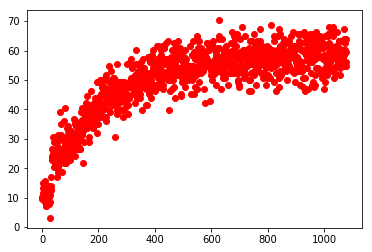

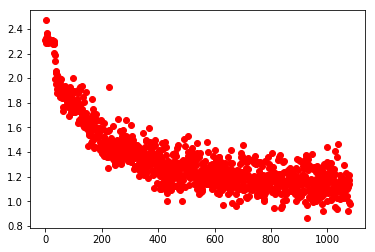

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

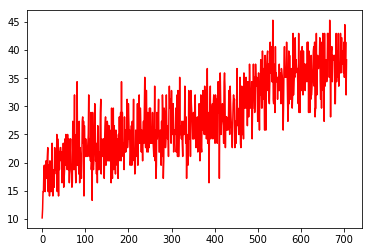

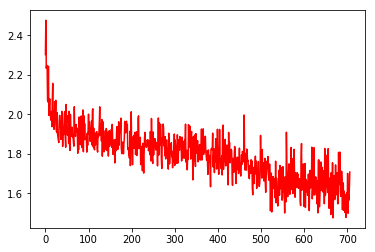

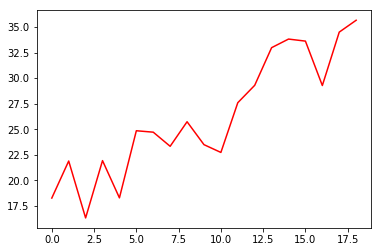

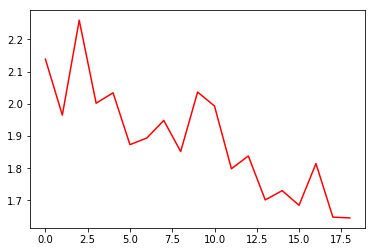

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()